# Project : 25-26: 4369 -- PROGRAMMING FOR DATA ANALYTICS


__Author    : Clyde Watts__  
__Lecturere : Andrew Beaty__  
__Date      : 2025-11-20__






## Introduction ##

This project will examine the data from a residintial solor system , and do interesting analysis.

- Part I  : Validate that exported power into grid and imported to grid match.
- Part II :Investigate if the power output can be predicted by looking at the weather.

The following data sets will be used

| Data Source | Description | File Type |
|:---|:---:|---:|
| Solis Inverter | This report contains various power KWh measurement for a day at an hour grain  | xls |
| Solis Inverter | This report contains various power KWh measurement for a month at an daily grain  | xls |
| Solis Inverter | This report contains various power KWh measurement for a year at an monthly grain  | xls |
| Bord Gas / ESB | This report contains daily export to grid | csv |
| MetEirn ? | Dublin Airport Weither  | csv / url |

__Imports__

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

__Globals__

![Roof](images\Picture_Of_Roof.png)

In [2]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 11
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


__Helper Functions__


[sqlite3 table schema](https://sqlite.org/faq.html#:~:text=If%20you%20are%20running%20the,including%20all%20tables%20and%20indices.)

In [3]:
def sqlite3_table_schema(conn, table_name):
    """
    Connects to the SQLite database at db_path and retrieves the schema of the specified table_name.
    Prints the schema in a formatted table.
    """
    csr = conn.cursor()
    csr.execute(f"PRAGMA table_info({table_name})")
    columns = csr.fetchall()

    print(f"--- Schema for '{table_name}' ---")
    print(f"{'ID':<5} {'Name':<15} {'Type':<10} {'NotNull':<10}")
    print("-" * 45)

    for col in columns:
        cid, name, dtype, notnull, dflt_value, pk = col
        print(f"{cid:<5} {name:<15} {dtype:<10} {notnull:<10}")


## Data Loads

__Database Setup__

In [4]:
print("Ensuring database directory exists...")
try:
    os.makedirs(f'{DATA_DIR}/db_sqlite/', exist_ok=True)
    print("Database directory ensured at:", f'{DATA_DIR}/db_sqlite/')
except Exception as e:
    print("Error creating database directory:", e)
print("Connecting to SQLite database...")
con = sqlite3.connect(SQL_DB_FILE)
sys_cur = con.cursor()
print("Connected to SQLite database at:", SQL_DB_FILE)

Ensuring database directory exists...
Database directory ensured at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//db_sqlite/
Connecting to SQLite database...
Connected to SQLite database at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//db_sqlite//big_project_db.sqlite3


### Solis Data Load

The solis data is manually extracted from the solas cloud client interface. This application requires a user logon and password

[Solis](https://www.soliscloud.com/)



### Load and Populate Solar Panel Data ###

The solar panel data is the yearly , monthly and daily inverter data from home solar system.  This data is retrieved from solas web site . The web site is a user logon website. The data had to be extracted manually , a period at a time. 

The data is placed in the directory ./big_project/data/raw_data/solar. 

[Home Solar System Website](https://www.soliscloud.com/station/stationDetails/generalSituation/1298491919449681542?glyun_vue2=%2F%23%2Fstation) 


[pandas read excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) 


[xlrd](https://pypi.org/project/xlrd/) 



In [5]:
# Load daily solar data
all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Daily*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%d-%m-%Y').date()
    else:
        print("DQ Issue: Date not found in header")
        break
    # Get Total Yield from header oday Yield(kWh):29.500kWh
    total_yield_label = df_header.iat[3,0]
    result_yield = re.search(r'oday Yield\(kWh\):([\d\.]+)kWh', str(total_yield_label))
    if result_yield:
        total_yield = float(result_yield.group(1))
    # The file needs to be read from line 29
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    all_dfs.append(df)
# Combine all at once
df_raw_daily_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
print("Loaded solar data shape:", df_raw_daily_solar.shape)
# Convert to Time column to datetime.time 12:23:45 format
df_raw_daily_solar['Time'] = pd.to_datetime(df_raw_daily_solar['Time'], format='%H:%M:%S').dt.time
# Combine Date and Time into a single DateTime column
df_raw_daily_solar['DateTime'] = df_raw_daily_solar.apply(lambda row: datetime.datetime.combine(row['Date'], row['Time']), axis=1)


# Display first few rows
df_raw_daily_solar.head()


Loaded solar data shape: (118142, 11)


,Date,Number,Time,Working State,PV(W),Battery(W),Grid(W),Load(W),SOC(%),Total_Yield(kWh),Source_File,DateTime
0,2024-09-12,1,00:00:00,Online,1.0,-115.72,6.0,0.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:00:00
1,2024-09-12,2,00:05:00,Online,1.0,-210.00,0.0,211.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:05:00
2,2024-09-12,3,00:10:00,Online,1.0,-199.50,1.0,0.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:10:00
3,2024-09-12,4,00:15:00,Online,1.0,-199.50,0.0,0.0,56.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:15:00
4,2024-09-12,5,00:20:00,Online,1.0,-194.25,77.0,0.0,56.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:20:00


__Write to CSV and Database

[to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)
[to_sql](https://pandas.pydata.org/pandas-docs/version/2.1.3/reference/api/pandas.DataFrame.to_sql.html)

In [6]:
print("Writing daily solar data to CSV...")
df_raw_daily_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_daily_solar.csv', index=False)
print(f"Wrote {len(df_raw_daily_solar)} rows to CSV.")
# Write to SQLite database
print("Writing daily solar data to SQLite database...")
row_count = df_raw_daily_solar.to_sql('daily_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM daily_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'daily_solar_data')


Writing daily solar data to CSV...
Wrote 118142 rows to CSV.
Writing daily solar data to SQLite database...
Wrote 118142 rows to SQLite database.
Verified 118142 rows in SQLite database.
--- Schema for 'daily_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     Date            DATE       0         
2     Number          INTEGER    0         
3     Time            TIME       0         
4     Working State   TEXT       0         
5     PV(W)           REAL       0         
6     Battery(W)      REAL       0         
7     Grid(W)         REAL       0         
8     Load(W)         REAL       0         
9     SOC(%)          REAL       0         
10    Total_Yield(kWh) REAL       0         
11    Source_File     TEXT       0         
12    DateTime        TIMESTAMP  0         


__Validate Solar dataframe__

Check for the following
1. Shape
2. Columns
3. Any dates missing
4. Row count per day

In [7]:
print("Combined DataFrame shape:", df_raw_daily_solar.shape)
print("DataFrame info:")
df_raw_daily_solar.info()
print("Columns:", df_raw_daily_solar.columns.tolist())
df_dates = df_raw_daily_solar['Date'].unique()
print(f"Dates Min: {min(df_dates)}")
print(f"Dates Max: {max(df_dates)}")
print("Total unique dates in data:", len(df_dates))
print("Date Range In Days:", (max(df_dates) - min(df_dates)).days)
# Delete all rows after 2025-10-31
df_raw_daily_solar = df_raw_daily_solar[df_raw_daily_solar['Date'] <= datetime.date(2025, 10, 31)]
# Adjusted shape after filtering dates
print("DataFrame shape after filtering dates:", df_raw_daily_solar.shape)
# find missing dates
# create a complete date range
all_dates = pd.date_range(start=min(df_dates), end=max(df_dates))
# get the difference between all_dates and df_dates
missing_dates = all_dates.difference(df_dates)
print("Missing dates:", missing_dates)


Combined DataFrame shape: (118142, 12)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118142 entries, 0 to 118141
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              118142 non-null  object        
 1   Number            118142 non-null  int64         
 2   Time              118142 non-null  object        
 3   Working State     118142 non-null  object        
 4   PV(W)             118142 non-null  float64       
 5   Battery(W)        118142 non-null  float64       
 6   Grid(W)           118142 non-null  float64       
 7   Load(W)           118142 non-null  float64       
 8   SOC(%)            118142 non-null  float64       
 9   Total_Yield(kWh)  118142 non-null  float64       
 10  Source_File       118142 non-null  object        
 11  DateTime          118142 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memor

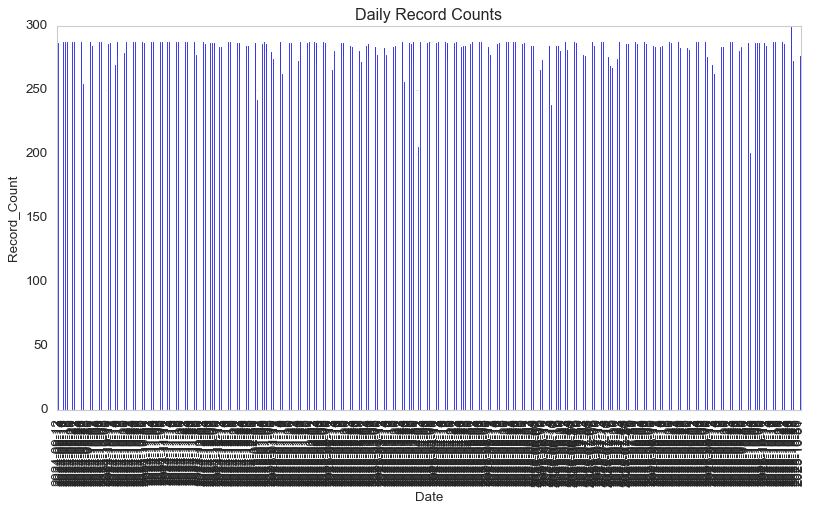

Outliers with MORE than 300 records:


,Date,Source_File


In [8]:
# Do a aggregation to daily level
df_date_counts = df_raw_daily_solar['Date'].value_counts().reset_index()
df_date_counts.columns = ['Date', 'Record_Count']
df_date_counts = df_date_counts.sort_values(by='Date')
# Plot the daily record counts
plt.figure(figsize=(12,6))
sns.barplot(data=df_date_counts, x='Date', y='Record_Count', color='blue')
plt.xticks(rotation=90)
plt.title('Daily Record Counts')
plt.show()
# print outliers where record count is less than 24
outliers = df_date_counts[df_date_counts['Record_Count'] > 300]
print("Outliers with MORE than 300 records:")
df_dups = df_raw_daily_solar[df_raw_daily_solar['Date'].isin(outliers['Date'])][['Date','Source_File']].drop_duplicates().sort_values(by='Date')
df_dups

#### Load Raw Monthly

In [9]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Monthly*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%m-%Y').date()
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df['Month'] = the_date
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    # Convert date column to date type format is dd-mm-yyyy
    #df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y').dt.date
    all_dfs.append(df)
# Combine all at once
df_raw_monthly_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_monthly_solar = df_raw_monthly_solar.rename(columns={'Time':'Date'})
# Convert Date column to date 
df_raw_monthly_solar['Date'] = pd.to_datetime(df_raw_monthly_solar['Date'], format='%d-%m-%Y').dt.date
# Set date as index
df_raw_monthly_solar.set_index('Date', inplace=True)


##### Write to CSV and Database

In [10]:
print("Writing monthly solar data to CSV...")
df_raw_monthly_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_monthly_solar.csv', index=False)
print(f"Wrote {len(df_raw_monthly_solar)} rows to CSV.")
# Write to SQLite database
print("Writing monthly solar data to SQLite database...")
row_count = df_raw_monthly_solar.to_sql('weekly_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM weekly_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'weekly_solar_data')

Writing monthly solar data to CSV...
Wrote 434 rows to CSV.
Writing monthly solar data to SQLite database...
Wrote 434 rows to SQLite database.
Verified 434 rows in SQLite database.
--- Schema for 'weekly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     Number          INTEGER    0         
2     Yield(kWh)      REAL       0         
3     Earning(EUR)    REAL       0         
4     Full Load Hours(h) REAL       0         
5     Charged(kWh)    REAL       0         
6     Discharged(kWh) REAL       0         
7     Exported(kWh)   REAL       0         
8     Imported(kWh)   REAL       0         
9     Net Import(kWh) REAL       0         
10    Load(kWh)       REAL       0         
11    Month           DATE       0         
12    Source_File     TEXT       0         


__Validate Raw Monthly__

TODO

In [11]:

print("Combined Monthly DataFrame shape:", df_raw_monthly_solar.shape)  
print("DataFrame info:")
df_raw_monthly_solar.info()
print("Columns:", df_raw_monthly_solar.columns.tolist())
print("First 5 rows:")

# get min and max Date columns that will indicate range
min_date = df_raw_monthly_solar.index.min()
max_date = df_raw_monthly_solar.index.max()
no_dates = (max_date - min_date).days + 1
print("No dates in range:", no_dates)
# Date datatype check
print("Date column datatype:", df_raw_monthly_solar.index.dtype)
print(f"Date range: {min_date} to {max_date}")
#no_of_days = (max_date - min_date).days + 1
#print(f"Total number of days in range: {no_of_days}")
# Count unique dates
unique_dates = df_raw_monthly_solar.index.nunique()
print(f"Unique dates count: {unique_dates}")
if unique_dates == no_dates:
    print("No missing dates in the monthly solar data.")

Combined Monthly DataFrame shape: (434, 12)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 2024-10-01 to 2024-09-30
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number              434 non-null    int64  
 1   Yield(kWh)          434 non-null    float64
 2   Earning(EUR)        434 non-null    float64
 3   Full Load Hours(h)  434 non-null    float64
 4   Charged(kWh)        434 non-null    float64
 5   Discharged(kWh)     434 non-null    float64
 6   Exported(kWh)       434 non-null    float64
 7   Imported(kWh)       434 non-null    float64
 8   Net Import(kWh)     434 non-null    float64
 9   Load(kWh)           434 non-null    float64
 10  Month               434 non-null    object 
 11  Source_File         434 non-null    object 
dtypes: float64(9), int64(1), object(2)
memory usage: 60.2+ KB
Columns: ['Number', 'Yield(kWh)', 'Earning(EUR)', 'Full Load Hours(h)', 'Ch

__Plot a few things to see how the data looks__

 Date                
 Yield(kWh)                 
 Full Load Hours(h)  
 Charged(kWh)        
 Discharged(kWh)     
 Exported(kWh)       
 Imported(kWh)       
 Net Import(kWh)     
 Load(kWh)           

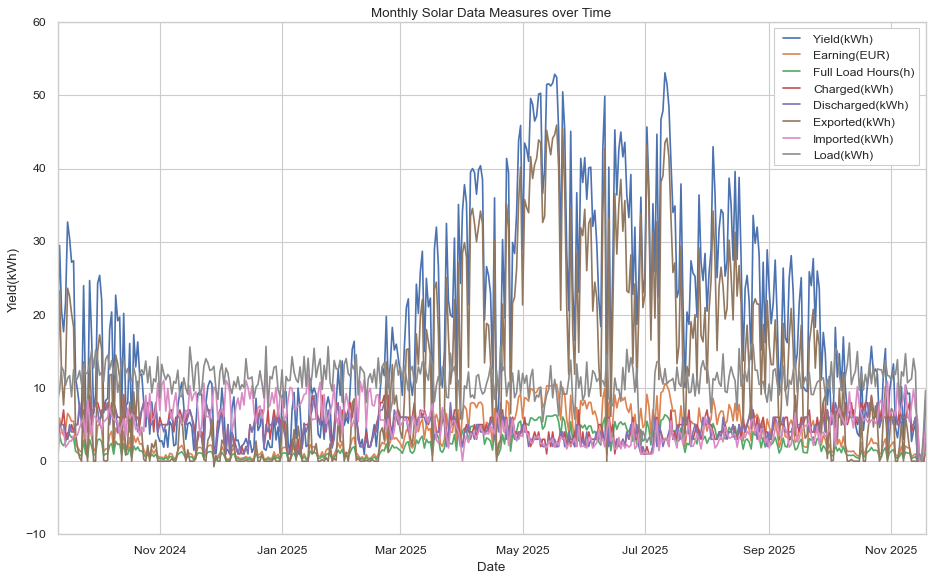

In [12]:
# plot date vs all the other measures in kWh on one plot
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Monthly Solar Data Measures over Time')
for column in df_raw_monthly_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_monthly_solar, x='Date', y=column, label=column)
plt.legend()
plt.show()

#### Load Yearly Raw Data

In [13]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Annual*xls'):
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    all_dfs.append(df)
# Combine all at once
df_raw_annual_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_annual_solar = df_raw_annual_solar.rename(columns={'Time':'Month'})
# Create Date column from Month
df_raw_annual_solar['Date'] = '01-' + df_raw_annual_solar['Month']
# Convert Date column to datetime
df_raw_annual_solar['Date'] = pd.to_datetime(df_raw_annual_solar['Date'], format='%d-%m-%Y').dt.date

    

__Validate Yearly__

In [14]:
print("Combined Annual DataFrame shape:", df_raw_annual_solar.shape)  
print("DataFrame info:")
df_raw_annual_solar.info()
print("Columns:", df_raw_annual_solar.columns.tolist())
df_raw_annual_solar.head(16)

Combined Annual DataFrame shape: (15, 14)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                15 non-null     object 
 1   Number              15 non-null     int64  
 2   Month               15 non-null     object 
 3   Yield(kWh)          15 non-null     float64
 4   Earning(EUR)        15 non-null     float64
 5   Full Load Hours(h)  15 non-null     float64
 6   Charged(kWh)        15 non-null     float64
 7   Discharged(kWh)     15 non-null     float64
 8   Exported(kWh)       15 non-null     float64
 9   Imported(kWh)       15 non-null     float64
 10  Net Import(kWh)     15 non-null     float64
 11  Load(kWh)           15 non-null     float64
 12  Total_Yield(kWh)    15 non-null     float64
 13  Source_File         15 non-null     object 
dtypes: float64(10), int64(1), object(3)
memory usage: 

,Date,Number,Month,Yield(kWh),Earning(EUR),Full Load Hours(h),Charged(kWh),Discharged(kWh),Exported(kWh),Imported(kWh),Net Import(kWh),Load(kWh),Total_Yield(kWh),Source_File
0,2025-01-01,1,01-2025,210.0,42.00,25.12,144.0,133.0,60.48,234.24,173.76,372.76,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
1,2025-02-01,2,02-2025,237.0,47.40,28.35,150.0,140.0,91.56,195.48,103.92,330.92,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
2,2025-03-01,3,03-2025,602.0,120.40,72.01,175.0,161.0,388.20,156.48,-231.72,356.28,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
3,2025-04-01,4,04-2025,896.0,179.20,107.18,139.0,131.0,687.36,116.04,-571.32,316.68,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
4,2025-05-01,5,05-2025,1280.0,256.00,153.11,101.0,92.0,1053.60,86.76,-966.84,304.16,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
5,2025-06-01,6,06-2025,994.5,198.90,118.96,100.0,93.0,755.64,78.60,-677.04,310.46,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
6,2025-07-01,7,07-2025,981.7,196.34,117.43,116.0,112.0,752.52,89.88,-662.64,315.06,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
7,2025-08-01,8,08-2025,878.0,175.60,105.02,144.0,132.0,624.60,113.40,-511.20,354.80,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
8,2025-09-01,9,09-2025,571.5,114.30,68.36,157.0,150.0,355.08,112.92,-242.16,322.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
9,2025-10-01,10,10-2025,292.1,58.42,34.94,203.0,192.0,107.52,197.76,90.24,371.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls


__Plot Data__

Plot to see what it looks like. Should see a bell like curve because of the seasonality



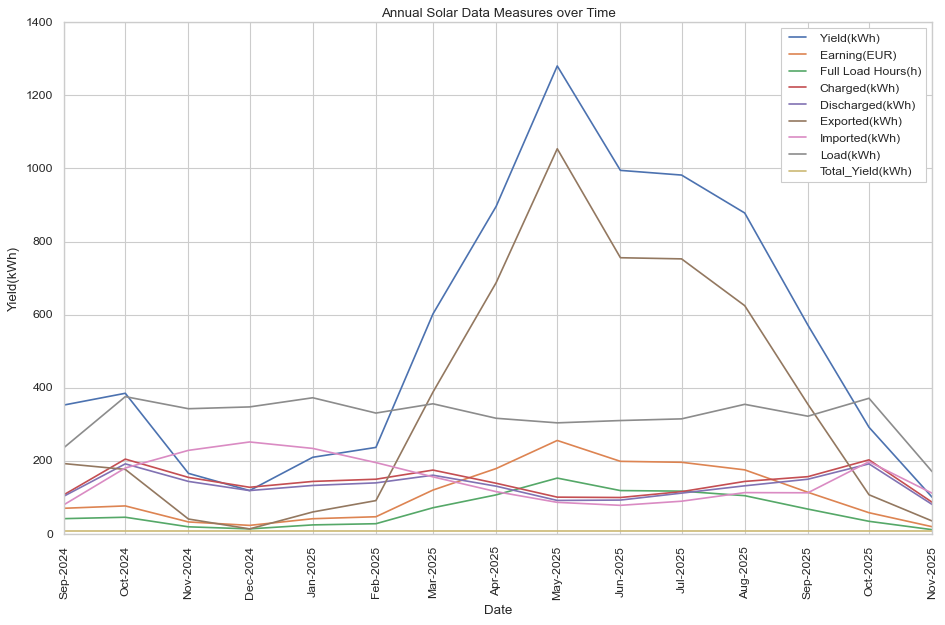

In [15]:
# plot date vs all the other measures in kWh on one plot
import matplotlib.dates as mdates
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Annual Solar Data Measures over Time')
for column in df_raw_annual_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_annual_solar, x='Date', y=column, label=column)
ax = plt.gca() # Get current axis

# 1. Set the Locator: Tell matplotlib to put a tick at every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# 2. Set the Formatter: Tell matplotlib how to write the text (e.g., Jan-2023)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# 3. Rotate ticks
plt.tick_params(axis='x', rotation=90)
plt.legend()
plt.show()

##### Write to CSV and Database

In [16]:
print("Writing yearly solar data to CSV...")
df_raw_annual_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_yearly_solar.csv', index=False)
print(f"Wrote {len(df_raw_annual_solar)} rows to CSV.")
# Write to SQLite database
print("Writing yearly solar data to SQLite database...")
row_count = df_raw_annual_solar.to_sql('monthly_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM monthly_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'monthly_solar_data')

Writing yearly solar data to CSV...
Wrote 15 rows to CSV.
Writing yearly solar data to SQLite database...
Wrote 15 rows to SQLite database.
Verified 15 rows in SQLite database.
--- Schema for 'monthly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     Date            DATE       0         
2     Number          INTEGER    0         
3     Month           TEXT       0         
4     Yield(kWh)      REAL       0         
5     Earning(EUR)    REAL       0         
6     Full Load Hours(h) REAL       0         
7     Charged(kWh)    REAL       0         
8     Discharged(kWh) REAL       0         
9     Exported(kWh)   REAL       0         
10    Imported(kWh)   REAL       0         
11    Net Import(kWh) REAL       0         
12    Load(kWh)       REAL       0         
13    Total_Yield(kWh) REAL       0         
14    Source_File     TEXT       0         


In [17]:
# List all tables in the database
sys_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = sys_cur.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
daily_dublin_weather_data
daily_esb_microgen_data
hourly_weather_data
hourly_solar_copernicus_data
hourly_solar_copernicus_enriched_data
daily_solar_data
weekly_solar_data
monthly_solar_data


### Load ESB Microgeneration Data

In [18]:
# load into pandas dataframe csv file
df_raw_esb_microgen = pd.read_csv(f'{RAW_DATA_DIR}/esb/BGE_Export_HDF_18_11_2025.csv')
# change Date column to date
df_raw_esb_microgen['Date'] = pd.to_datetime(df_raw_esb_microgen['Date']).dt.date 
# change Date to index
df_raw_esb_microgen.set_index('Date', inplace=True)

In [19]:
print("ESB Microgen DataFrame shape:", df_raw_esb_microgen.shape)
print("DataFrame info:")
df_raw_esb_microgen.info()
print("Columns:", df_raw_esb_microgen.columns.tolist())
print("First 5 rows:")
print(df_raw_esb_microgen.head())


ESB Microgen DataFrame shape: (435, 3)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 2024-09-05 to 2025-11-13
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MPRN                 435 non-null    int64  
 1   Export Volume (kWh)  435 non-null    float64
 2   Export Type          435 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 13.6+ KB
Columns: ['MPRN', 'Export Volume (kWh)', 'Export Type']
First 5 rows:
                  MPRN  Export Volume (kWh) Export Type
Date                                                   
2024-09-05  9999999999                  0.0     Metered
2024-09-06  9999999999                  0.0     Metered
2024-09-07  9999999999                  0.0     Metered
2024-09-08  9999999999                  0.0     Metered
2024-09-09  9999999999                  0.0     Metered


#### Write to CSV and Database

In [20]:
print("Writing daily ESB microgen data to CSV...")
df_raw_esb_microgen.to_csv(f'{DATA_DIR}/processed_data/df_raw_daily_esb_microgen.csv', index=False)
print(f"Wrote {len(df_raw_esb_microgen)} rows to CSV.")
# Write to SQLite database
print("Writing daily ESB microgen data to SQLite database...")
row_count = df_raw_esb_microgen.to_sql('daily_esb_microgen_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM daily_esb_microgen_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'daily_esb_microgen_data')

Writing daily ESB microgen data to CSV...
Wrote 435 rows to CSV.
Writing daily ESB microgen data to SQLite database...
Wrote 435 rows to SQLite database.
Verified 435 rows in SQLite database.
--- Schema for 'daily_esb_microgen_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     MPRN            INTEGER    0         
2     Export Volume (kWh) REAL       0         
3     Export Type     TEXT       0         


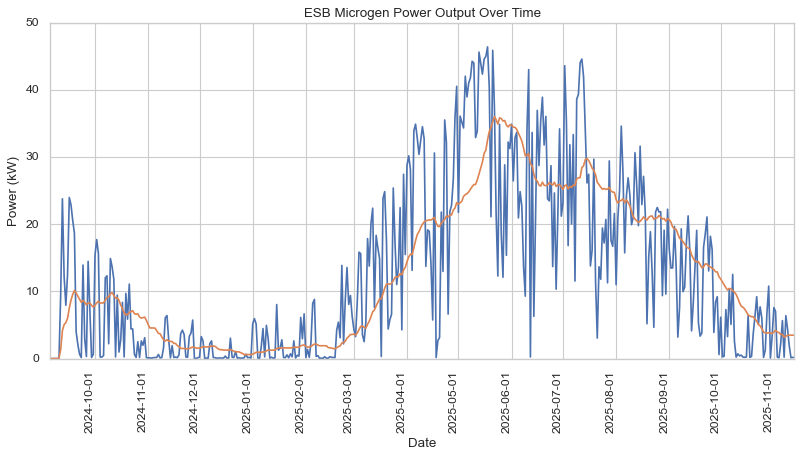

In [21]:

# Plot esb microgen data
plt.figure(figsize=(12,6))
ss = df_raw_esb_microgen['Export Volume (kWh)']
ss.plot()
# plot a smooth line
ss.rolling(window=30,min_periods=1).mean().plot()
plt.title('ESB Microgen Power Output Over Time')
plt.xlabel('Date')
# set x axis major ticks to monthly at 90 degrees
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate(rotation=90)
plt.ylabel('Power (kW)')
plt.grid(True)
plt.show()

### Load  Weather Data

The first iteration the local weather was downloaded from Data.gov.ie - Dublin Airport Hourly Data. After some investigation , a more general source was found Meteostat was found. This gives a similar data set to data.gov.ie with the advantage that it downloads directly into a dataframe , and it has a local cache.

[Meteostat](https://meteostat.net/en/)  
[Meteostat Columns](https://dev.meteostat.net/formats.html#time-format)  
[Dublin Airport Hourly Data](https://data.gov.ie/dataset/dublin-airport-hourly-data)  
[Dublin Airport Weather](https://cli.fusio.net/cli/climate_data/webdata/hly532.csv)  



In [22]:
# Load hourly weather data for Dublin
#df_weather_dublin = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/hly532.csv', skiprows=23)
mt.Stations.cache_dir = METEOSTAT_CACHE_DIR
stations = mt.Stations()
# Get the stations near the specified latitude and longitude
stations = stations.nearby(LATITUDE, LONGITUDE)
# Get the first station from the list , which is usually the closest one
df_station = stations.fetch(1)
# Reset index to access station ID
df_station.reset_index(inplace=True)
print(f"Station ID: {df_station['id'][0]}")
print(f"Station Name: {df_station['name'][0]}")
print(f"Station Distance: {df_station['distance'][0]:.2f} m")
# Get local station ID
station_id = df_station['id'][0]
# Get hourly data
data = mt.Hourly(station_id, WEATHER_START_DATE, WEATHER_END_DATE,timezone='Europe/Dublin')
# fetch the data
weather_df = data.fetch()
# set index to default integer index
weather_df.reset_index(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0].to_string())
# fix missing values by forward filling and then backward filling
weather_df.ffill(inplace=True)
weather_df.bfill(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0].to_string())
# explode the dataframe time to 10 minute intervals
weather_df.set_index('time', inplace=True)
weather_df = weather_df.resample('10T').interpolate(method='linear')
weather_df.reset_index(inplace=True)
# we are only interested in time, temperature, humidity, and solar radiation
weather_df = weather_df[['time', 'temp', 'rhum', 'tsun','coco']]
# rename columns for clarity
weather_df.rename(columns={'time': 'DateTime', 'temp': 'Temperature(C)', 'rhum': 'Humidity(%)', 'tsun': 'Solar Radiation(W/m^2)','coco': 'Condition Code'}, inplace=True)
# Change DateTime - Drop timezone info to Europe/Dublin need that later for merging with other data
weather_df['DateTime'] = weather_df['DateTime'].dt.tz_convert('Europe/Dublin').dt.tz_localize(None)
print("Weather DataFrame shape:", weather_df.shape)
print("DataFrame info:")
weather_df.info()
print("Columns:", weather_df.columns.tolist())
print("First 5 rows:")
print(weather_df.head())

Station ID: 03969
Station Name: Dublin Airport
Station Distance: 29619.04 m
Missing values in each column:
prcp      483
snow    16134
Missing values in each column:
Series([], )
Weather DataFrame shape: (100885, 5)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100885 entries, 0 to 100884
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                100885 non-null  datetime64[ns]
 1   Temperature(C)          100885 non-null  Float64       
 2   Humidity(%)             100885 non-null  Float64       
 3   Solar Radiation(W/m^2)  100885 non-null  Float64       
 4   Condition Code          100885 non-null  Float64       
dtypes: Float64(4), datetime64[ns](1)
memory usage: 4.2 MB
Columns: ['DateTime', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code']
First 5 rows:
             DateTime  Temperature(C)  Humidity(%)  Solar R

#### Write to CSV and Database

In [23]:
print("Writing daily Dublin weather data to CSV...")
weather_df.to_csv(f'{DATA_DIR}/processed_data/df_weather.csv', index=False)
print(f"Wrote {len(weather_df)} rows to CSV.")
# Write to SQLite database
print("Writing daily Dublin weather data to SQLite database...")
row_count = weather_df.to_sql('hourly_weather_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM hourly_weather_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'hourly_weather_data')

Writing daily Dublin weather data to CSV...
Wrote 100885 rows to CSV.
Writing daily Dublin weather data to SQLite database...
Wrote 100885 rows to SQLite database.
Verified 100885 rows in SQLite database.
--- Schema for 'hourly_weather_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     DateTime        TIMESTAMP  0         
2     Temperature(C)  REAL       0         
3     Humidity(%)     REAL       0         
4     Solar Radiation(W/m^2) REAL       0         
5     Condition Code  REAL       0         


#### Validate Data

Plot the temperature , humidity and solar radiation over time. There are 10K rows , thus it takes some time.
Notice how irish weather is inconsistent. This makes trying to find predict solar output from weather a challenge.



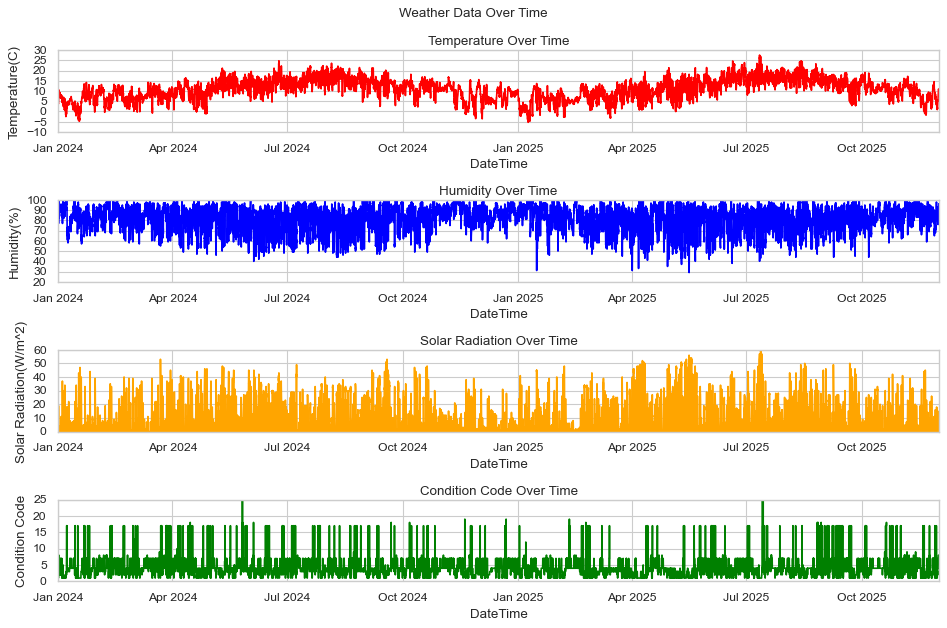

In [24]:
#
fig,ax = plt.subplots(4,1,figsize=(12,8))

fig.suptitle('Weather Data Over Time')

sns.lineplot(data=weather_df, x='DateTime', y='Temperature(C)', ax=ax[0], color='red')
ax[0].set_title('Temperature Over Time')
sns.lineplot(data=weather_df, x='DateTime', y='Humidity(%)', ax=ax[1], color='blue')
ax[1].set_title('Humidity Over Time')
sns.lineplot(data=weather_df, x='DateTime', y='Solar Radiation(W/m^2)', ax=ax[2], color='orange')
ax[2].set_title('Solar Radiation Over Time')
sns.lineplot(data=weather_df, x='DateTime', y='Condition Code', ax=ax[3], color='green')
ax[3].set_title('Condition Code Over Time')
plt.tight_layout()
plt.show()

### Load Copernicus - Atmosphere Data Store

This is one of the best sources of solar radiation at a ground level. It is based on saterlite data from copernicus . I also looks at Nasa and other sources , this looked like the best , and most up to date. The data could either be extracted from the site via a request or via a python API. The API requird a key which would make the project uncessarly complicated. A file was used with a granulary of of 1 minute which was initially 70 MB big , and is reduced to 10 minute granularity before being saved. 
The measure to do the analysis at later stages will be GHI - Global Horizonal All Sky Irradiation ( Gemini ). This is the sum of direct and indirect radiation . It does not take into account the angle and direction of the solar panels . This will be a challenge because it is a split system pointing W and E. 

(Copernicus - Atmosphere Data Store)[https://ads.atmosphere.copernicus.eu/requests?tab=all]


(CAMS - Solar Radiation Timeseries)[https://ads.atmosphere.copernicus.eu/datasets/cams-solar-radiation-timeseries?tab=overview]

In [25]:
# Stored Copernicus solar data local file path - if this file load locally and alighn with 10 minute intervals
copernicus_local_file_name="C:/tmp/coperinicus_bettystown_solar_data.csv"
copernicus_project_file_name=f"{RAW_DATA_DIR}/Copernicus_Solar_Data_Bettystown_2024_2025.csv"
# Load from local file if it exists and write to project raw data folder
if os.path.exists(copernicus_local_file_name):
    print("Loading Copernicus solar data from local file...")
    df_copernicus_solar = pd.read_csv(copernicus_local_file_name,skiprows=42,sep=';')
    print("Copernicus Solar DataFrame shape:", df_copernicus_solar.shape)
    print("DataFrame info:")
    df_copernicus_solar.info()
    print("Columns:", df_copernicus_solar.columns.tolist())
    # format of first column is 2024-09-01T00:00:00.0/2024-09-01T00:01:00.0
    # split on / to get from and to datetime
    df_copernicus_solar[['From_datetime','To_datetime']] = df_copernicus_solar['# Observation period'].str.split('/', expand=True)
    # Split first into from datetime and todatetime columns in first and second column
    # Convert From_datetime to datetime format
    df_copernicus_solar['From_datetime'] = pd.to_datetime(df_copernicus_solar['From_datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
    # Drop to_datetime column
    df_copernicus_solar.drop(columns=['To_datetime'], inplace=True)
    # Rename From_datetime to DateTime
    df_copernicus_solar.rename(columns={'From_datetime': 'DateTime'}, inplace=True)
    # Set to DateTime to index
    df_copernicus_solar.set_index('DateTime', inplace=True)
    # Resample to 10 minute intervals using sum because measures are at 1 minute intervals
    # Sample spans sufficient data points to cover full 10 minute interval
    df_copernicus_solar = df_copernicus_solar.resample('10min').sum(min_count=9).reset_index()
    # Convert Time into time only
    df_copernicus_solar['Time'] = df_copernicus_solar['DateTime'].dt.time
    # Convert Date into date only
    df_copernicus_solar['Date'] = df_copernicus_solar['DateTime'].dt.date
    print("After resampling to 10 minute intervals:")
    print("Copernicus Solar DataFrame shape:", df_copernicus_solar.shape)
    print("DataFrame info:")
    df_copernicus_solar.info()
    print("Columns:", df_copernicus_solar.columns.tolist())
    print("First 5 rows:")
    print(df_copernicus_solar.head())
    # Now write to project raw data folder
    print("Writing Copernicus solar data to project raw data folder...")
    df_copernicus_solar.to_csv(copernicus_project_file_name, index=False)


# Now load from project folder - normal status
print("Loading Copernicus solar data from project raw data folder...")
df_copernicus_solar = pd.read_csv(copernicus_project_file_name)
# Convert Time into time only
df_copernicus_solar['Time'] = pd.to_datetime(df_copernicus_solar['Time'], format='%H:%M:%S').dt.time
# Convert Date into date only
df_copernicus_solar['Date'] = pd.to_datetime(df_copernicus_solar['Date'], format='%Y-%m-%d').dt.date

print("Copernicus Solar DataFrame shape:", df_copernicus_solar.shape)
print("DataFrame info:")
df_copernicus_solar.info()
print("Columns:", df_copernicus_solar.columns.tolist())
# Convert DateTime to datetime format
print("First 5 rows:")
print(df_copernicus_solar.head())
df_copernicus_solar['DateTime'] = pd.to_datetime(df_copernicus_solar['DateTime'], format='%Y-%m-%d %H:%M:%S')

Loading Copernicus solar data from local file...
Copernicus Solar DataFrame shape: (653760, 11)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653760 entries, 0 to 653759
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   # Observation period  653760 non-null  object 
 1   TOA                   653760 non-null  float64
 2   Clear sky GHI         653760 non-null  float64
 3   Clear sky BHI         653760 non-null  float64
 4   Clear sky DHI         653760 non-null  float64
 5   Clear sky BNI         653760 non-null  float64
 6   GHI                   653760 non-null  float64
 7   BHI                   653760 non-null  float64
 8   DHI                   653760 non-null  float64
 9   BNI                   653760 non-null  float64
 10  Reliability,          653760 non-null  object 
dtypes: float64(9), object(2)
memory usage: 54.9+ MB
Columns: ['# Observation period', 'TOA', 'Clear 

#### Write to CSV and Database

In [26]:
print("Writing daily Copernicus solar data to CSV...")
df_copernicus_solar.to_csv(f'{DATA_DIR}/processed_data/Copernicus_Solar_Data_Bettystown_2024_2025.csv', index=False)
print(f"Wrote {len(df_copernicus_solar)} rows to CSV.")
# Write to SQLite database
print("Writing daily Copernicus solar data to SQLite database...")
row_count = df_copernicus_solar.to_sql('hourly_solar_copernicus_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM hourly_solar_copernicus_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'hourly_solar_copernicus_data')

Writing daily Copernicus solar data to CSV...
Wrote 65376 rows to CSV.
Writing daily Copernicus solar data to SQLite database...
Wrote 65376 rows to SQLite database.
Verified 65376 rows in SQLite database.
--- Schema for 'hourly_solar_copernicus_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     DateTime        TIMESTAMP  0         
2     # Observation period TEXT       0         
3     TOA             REAL       0         
4     Clear sky GHI   REAL       0         
5     Clear sky BHI   REAL       0         
6     Clear sky DHI   REAL       0         
7     Clear sky BNI   REAL       0         
8     GHI             REAL       0         
9     BHI             REAL       0         
10    DHI             REAL       0         
11    BNI             REAL       0         
12    Reliability,    TEXT       0         
13    Time            TIME       0         
14    Date            DATE       

#### Validate Data

This is plotting data 

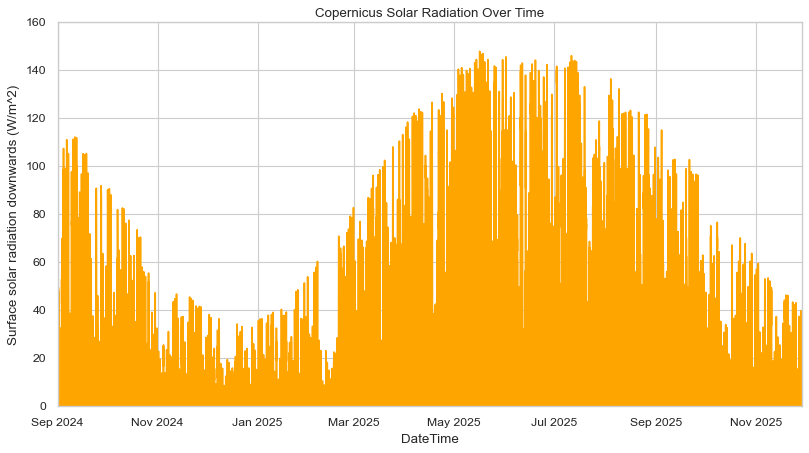

In [27]:
# Plot the Copernicus solar data
plt.figure(figsize=(12,6))
sns.lineplot(data=df_copernicus_solar, x='DateTime', y='GHI', color='orange')
plt.title('Copernicus Solar Radiation Over Time')
plt.xlabel('DateTime')
plt.ylabel('Surface solar radiation downwards (W/m^2)')
plt.show()

__Plot the 1st of each month Sept 2024 to Sept 2025__

12 small plots for 1st of each month

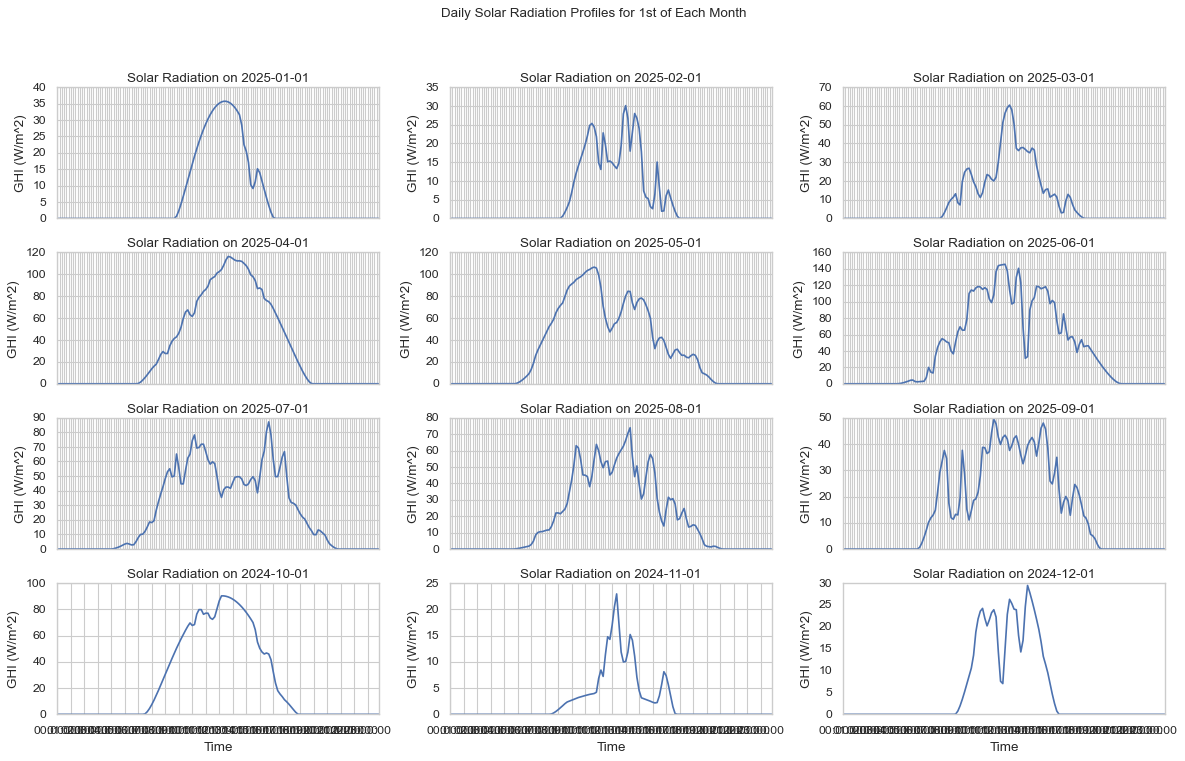

In [28]:
fig,ax = plt.subplots(4,3,figsize=(15,10))
df_temp = df_copernicus_solar[df_copernicus_solar['DateTime'].dt.day == 1 ][['DateTime','Date','Time','GHI']].copy()
# exclude rows > date > 2025-10-01
df_temp = df_temp[df_temp['DateTime'] <= datetime.datetime(2025, 9, 1)]
# Convert Time to string for plotting
df_temp['Time'] = df_temp['Time'].astype(str)
plt.grid(False)
fig.suptitle('Daily Solar Radiation Profiles for 1st of Each Month')
for date in df_temp['Date'].unique():
    df_day = df_temp[df_temp['Date'] == date]
    day = df_day['DateTime'].dt.day.iloc[0]
    month = df_day['DateTime'].dt.month.iloc[0]
    year = df_day['DateTime'].dt.year.iloc[0]
    ax_idx_row = (month - 1) // 3
    ax_idx_col = (month - 1) % 3
    sns.lineplot(data=df_day, x='Time', y='GHI', ax=ax[ax_idx_row, ax_idx_col])
    ax[ax_idx_row, ax_idx_col].set_title(f'Solar Radiation on {year}-{month:02d}-{day:02d}')
    if ax_idx_row < 3:
        ax[ax_idx_row, ax_idx_col].set_xlabel('')
    else:
        ax[ax_idx_row, ax_idx_col].set_xlabel('Time')
    ax[ax_idx_row, ax_idx_col].set_ylabel('GHI (W/m^2)')
    # Rotate x-axis labels for better readability
    # only plot x tick labels on bottom row
    if ax_idx_row == 3:
        # only plot 1 per hour to avoid clutter
        ax[ax_idx_row, ax_idx_col].set_xticks(ax[ax_idx_row, ax_idx_col].get_xticks()[::6])
        #ax[ax_idx_row, ax_idx_col].tick_params(axis='x', rotation=90)
    else:
        ax[ax_idx_row, ax_idx_col].set_xticklabels([])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Load / Enrich Copericus Data

The PVLIB python library is used to calculate the solar (PV - photo-volatic) system performance based on the solar radiation , the angle of the roof , the azmith of the roof , and where it is. The solar panel angle , hozintal and vertical , impact the efficiency. This is depends on the time day and time of year. The path the sun takes varies based on the time of year.



[PVLIB Documentation](https://pvlib-python.readthedocs.io/en/stable/)    
[Gemini Prompt](https://gemini.google.com/share/54cd534a5aeb)

In [29]:
import pvlib
df_copernicus_solar_enriched = df_copernicus_solar.copy()

# Set up location
print("Setting up PVLib location...")
location = pvlib.location.Location(latitude=LATITUDE, longitude=LONGITUDE, tz='Europe/Dublin')
print("Location set for PVLib:", location)

# Set DateTime as index for PVLib calculations
df_copernicus_solar_enriched.set_index('DateTime', inplace=True)

# Get solar position
print("Calculating solar position using PVLib...")
solar_position = location.get_solarposition(times=df_copernicus_solar_enriched.index)

# PANE I configuration
print("Calculating solar position and POA irradiance using PVLib...")
poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=ROOF_PANE_I_ANGLE,
    surface_azimuth=ROOF_PANE_I_AZIMUTH,
    dni=df_copernicus_solar_enriched['BNI'],
    ghi=df_copernicus_solar_enriched['GHI'],
    dhi=df_copernicus_solar_enriched['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

# Add POA to dataframe
df_copernicus_solar_enriched['POA_Pane_I(W/m^2)'] = poa['poa_global']

# PANE II configuration
poa_ii = pvlib.irradiance.get_total_irradiance(
    surface_tilt=ROOF_PANE_II_ANGLE,
    surface_azimuth=ROOF_PANE_II_AZIMUTH,
    dni=df_copernicus_solar_enriched['BNI'],
    ghi=df_copernicus_solar_enriched['GHI'],
    dhi=df_copernicus_solar_enriched['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

# Add POA to dataframe
df_copernicus_solar_enriched['POA_Pane_II(W/m^2)'] = poa_ii['poa_global']

# Calculate power output for each pane
df_copernicus_solar_enriched['Power_Pane_I(W)'] = (df_copernicus_solar_enriched['POA_Pane_I(W/m^2)'] * TOTAL_SOLAR_PANE_I_CAPACITY_W * 6) / 1000.0
df_copernicus_solar_enriched['Power_Pane_II(W)'] = (df_copernicus_solar_enriched['POA_Pane_II(W/m^2)'] * TOTAL_SOLAR_PANE_II_CAPACITY_W * 6) / 1000.0

# Total Power Output
df_copernicus_solar_enriched['Total_Power_Output(W)'] = df_copernicus_solar_enriched['Power_Pane_I(W)'] + df_copernicus_solar_enriched['Power_Pane_II(W)']

# Reset index if you want DateTime as a column again
df_copernicus_solar_enriched.reset_index(inplace=True)

print("PVLib calculations complete.")

Setting up PVLib location...
Location set for PVLib: Location: 
  name: None
  latitude: 53.6985
  longitude: -6.208
  altitude: 26.0
  tz: Europe/Dublin
Calculating solar position using PVLib...
Calculating solar position and POA irradiance using PVLib...
PVLib calculations complete.


#### Write to CSV and Database

In [30]:
print("Writing daily Copernicus solar enriched data to CSV...")
df_copernicus_solar_enriched.to_csv(f'{DATA_DIR}/processed_data/Copernicus_Solar_Data_Bettystown_Enriched_2024_2025.csv', index=False)
print(f"Wrote {len(df_copernicus_solar_enriched)} rows to CSV.")
# Write to SQLite database
print("Writing daily Copernicus solar data to SQLite database...")
row_count = df_copernicus_solar_enriched.to_sql('hourly_solar_copernicus_enriched_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM hourly_solar_copernicus_enriched_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'hourly_solar_copernicus_enriched_data')

Writing daily Copernicus solar enriched data to CSV...
Wrote 65376 rows to CSV.
Writing daily Copernicus solar data to SQLite database...
Wrote 65376 rows to SQLite database.
Verified 65376 rows in SQLite database.
--- Schema for 'hourly_solar_copernicus_enriched_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     DateTime        TIMESTAMP  0         
2     # Observation period TEXT       0         
3     TOA             REAL       0         
4     Clear sky GHI   REAL       0         
5     Clear sky BHI   REAL       0         
6     Clear sky DHI   REAL       0         
7     Clear sky BNI   REAL       0         
8     GHI             REAL       0         
9     BHI             REAL       0         
10    DHI             REAL       0         
11    BNI             REAL       0         
12    Reliability,    TEXT       0         
13    Time            TIME       0         
14    Date     

#### Validate Data

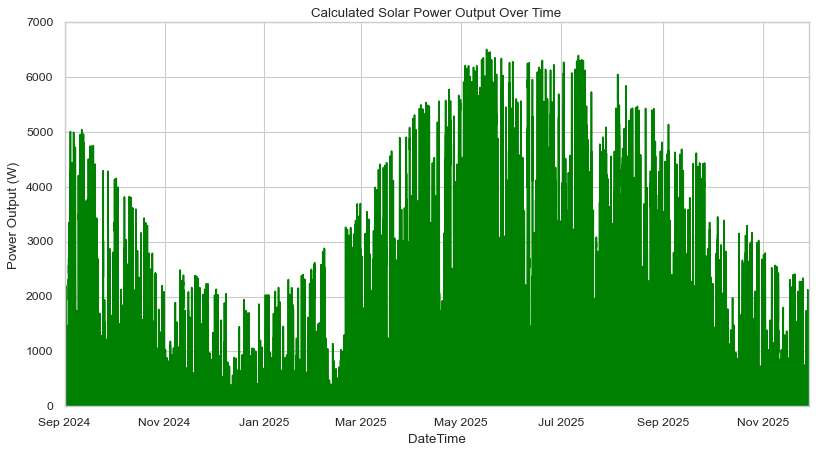

In [31]:
# Plot the calculated power output
plt.figure(figsize=(12,6))
sns.lineplot(data=df_copernicus_solar_enriched, x='DateTime', y='Total_Power_Output(W)', color='green')
plt.title('Calculated Solar Power Output Over Time')
plt.xlabel('DateTime')
plt.ylabel('Power Output (W)')
plt.show()


__Plot 1 per month__

Plot 1st of each month , the individual panels ( pane 1 and pane 2 ) , and the total. 

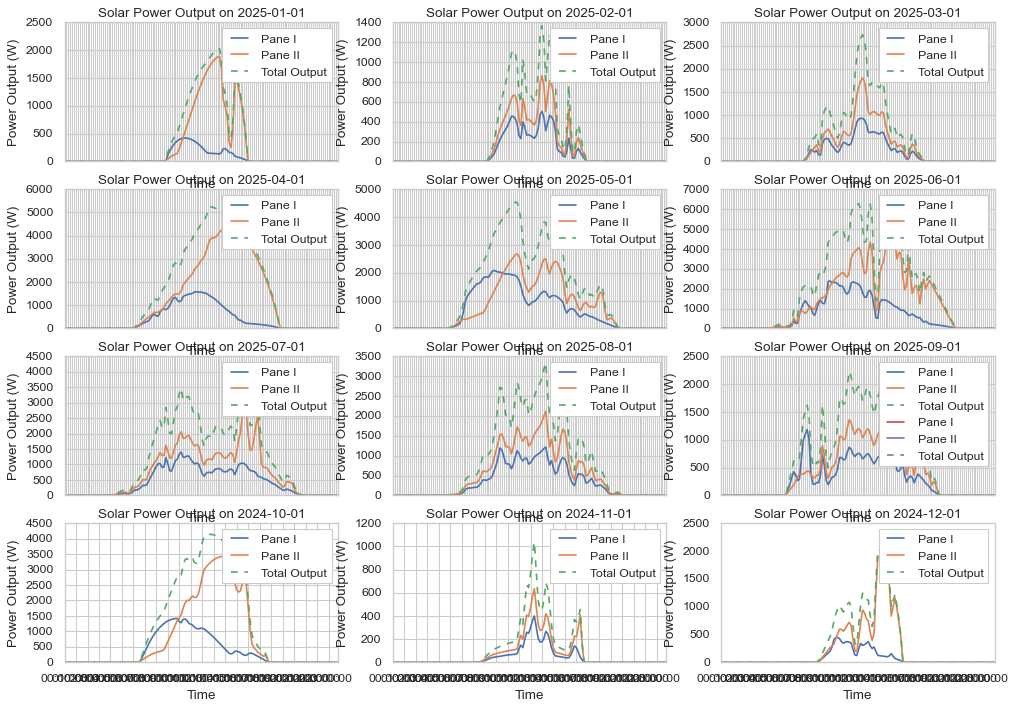

In [32]:
# Plot 1 day per month for each month include both panes and total power output

fig,ax = plt.subplots(4,3,figsize=(15,10))
df_temp = df_copernicus_solar_enriched.copy()
# Convert Time to string for plotting
df_temp['Time'] = df_temp['Time'].astype(str)
# reset index to get DateTime as column
df_temp.reset_index(inplace=True)
df_temp = df_temp[df_temp['DateTime'].dt.day == 1][['DateTime','Date','Time','Power_Pane_I(W)','Power_Pane_II(W)','Total_Power_Output(W)']].copy()
# exclude rows > date > 2025-10-01
df_temp = df_temp[df_temp['DateTime'] <= datetime.datetime(2025, 9, 1)]
plt.grid(False)
for date in df_temp['Date'].unique():
    df_day = df_temp[df_temp['Date'] == date]
    day = df_day['DateTime'].dt.day.iloc[0]
    month = df_day['DateTime'].dt.month.iloc[0]
    year = df_day['DateTime'].dt.year.iloc[0]
    ax_idx_row = (month - 1) // 3
    ax_idx_col = (month - 1) % 3
    sns.lineplot(data=df_day, x='Time', y='Power_Pane_I(W)', ax=ax[ax_idx_row, ax_idx_col], label='Pane I')
    sns.lineplot(data=df_day, x='Time', y='Power_Pane_II(W)', ax=ax[ax_idx_row, ax_idx_col], label='Pane II')
    sns.lineplot(data=df_day, x='Time', y='Total_Power_Output(W)', ax=ax[ax_idx_row, ax_idx_col], label='Total Output', linestyle='--')
    ax[ax_idx_row, ax_idx_col].set_title(f'Solar Power Output on {year}-{month:02d}-{day:02d}')
    #ax[ax_idx_row, ax_idx_col].set_xlabel('Time')
    # Dont display x label for all but bottom plots only plot every hour
    if ax_idx_row < 3:
        #ax[ax_idx_row, ax_idx_col].set_xlabel('')
        ax[ax_idx_row, ax_idx_col].set_xticklabels([])
    else:
        #ax[ax_idx_row, ax_idx_col].set_xlabel('Time')
        # only plot 1 per hour to avoid clutter
        ax[ax_idx_row, ax_idx_col].set_xticks(ax[ax_idx_row, ax_idx_col].get_xticks()[::6])
    ax[ax_idx_row, ax_idx_col].set_ylabel('Power Output (W)')
    #ax[ax_idx_row, ax_idx_col].tick_params(axis='x', rotation=90)
    ax[ax_idx_row, ax_idx_col].legend()

__Plot Summer Soltice__


df_temp_cop shape: ['Date', 'Number', 'Time', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime'] (288, 12)


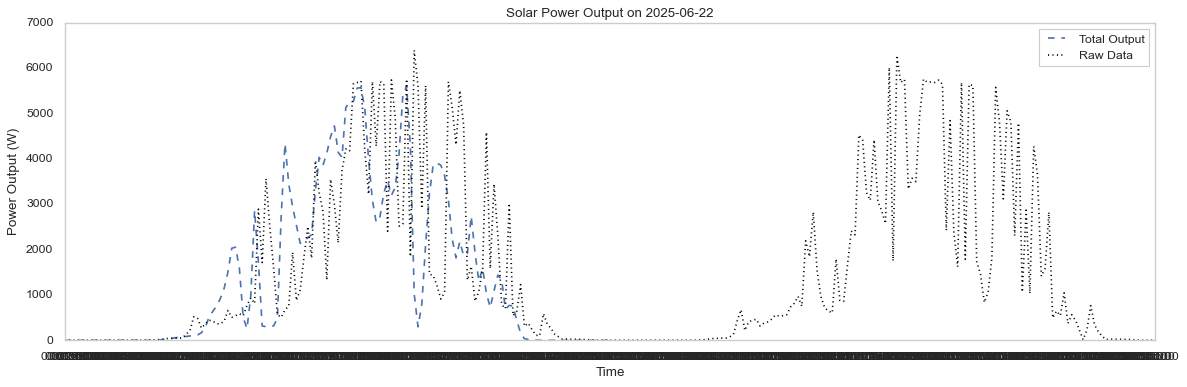

In [33]:
fig, ax = plt.subplots(figsize=(15,5))  # Changed from 'ig' to 'fig'
df_temp_cop = df_copernicus_solar_enriched[df_copernicus_solar_enriched['DateTime'].dt.date == pd.to_datetime('2025-06-22').date()].copy()  
df_temp_raw = df_raw_daily_solar[df_raw_daily_solar['Date'] == pd.to_datetime('2025-06-22').date()].copy()
print("df_temp_cop shape:", df_temp_raw.columns.tolist(), df_temp_raw.shape)
# convert Time to string for plotting
df_temp_raw['Time'] = df_temp_raw['Time'].astype(str)
df_temp_cop['Time'] = df_temp_cop['Time'].astype(str)
# reset index to get DateTime as column
df_temp_cop.reset_index(inplace=True)
df_temp_cop = df_temp_cop[df_temp_cop['DateTime'].dt.date == pd.to_datetime('2025-06-22').date()][['DateTime','Date','Time','Power_Pane_I(W)','Power_Pane_II(W)','Total_Power_Output(W)']].copy()
#sns.lineplot(data=df_temp_cop, x='Time', y='Power_Pane_I(W)', ax=ax, label='Pane I')
#sns.lineplot(data=df_temp_cop, x='Time', y='Power_Pane_II(W)', ax=ax, label='Pane II')
sns.lineplot(data=df_temp_cop, x='Time', y='Total_Power_Output(W)', ax=ax, label='Total Output', linestyle='--')
sns.lineplot(data=df_temp_raw, x='Time', y='PV(W)', ax=ax, label='Raw Data', color='black', linestyle=':')
ax.set_title(f'Solar Power Output on 2025-06-22')
ax.set_ylabel('Power Output (W)')
ax.legend()

#ax.xaxis.set_major_locator(plt.matplotlib.dates.HourLocator())

#a#x.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
ax.grid(False)
plt.tight_layout()
plt.show()

## Examining Inverter Export Measurement and Utility Import Measurement

__Introduction__

The home solar system measures the energy exported to the grid (kWh), while the Utility (ESB) measures the microgeneration import (kWh). This section compares these two datasets.

Initially conceived as an audit of the measurements—essentially asking, "Am I being ripped off?"—this analysis has evolved into an interesting comparison of two distinct measurement methods applied to the same energy flow.


![House/ESB](images/ESB_SOLAR.drawio.png)

- **Output measurement:**
  - Source: Monthly Export From Inverter
  - DataFrame: `df_raw_monthly_solar`
  - Table: weekly_solar_data
- **Input measurement:**
  - Source: ESB Microgeneration
  - DataFrame: `df_raw_esb_microgen`
  - Table: daily_esb_microgen_data



### Step 1: Audit Export Data Integrity

A critical step in our analysis is to ensure the integrity of our data sources. We will validate the solar export data by comparing measurements from the solar inverter against the official ESB smart meter readings.

**Methodology:**

The analysis involves two key tables:
1.  `weekly_solar_data`: Contains daily export data from the solar inverter, specifically the `Exported(kWh)` column.
2.  `daily_esb_microgen`: Contains daily export data from the ESB meter, found in the `Export Volume (kWh)` column.

These tables were aggregated to calculate the total exported energy from each source over the entire period.

**Results & Analysis:**

The comparison of the total summed exports is as follows:

| Data Source | Total Export |
| :--- | :--- |
| ESB Meter | 5473.47 kWh |
| Solar Inverter | 5337.72 kWh |
| **Difference** | **-135.75 kWh (-0.63%)** |

The analysis reveals a -0.63% percentage difference, with the solar inverter reporting a lower export value than the ESB meter. This result is counter-intuitive. Standard electrical principles suggest that energy losses (line losses) occur between the point of generation (the inverter) and the grid connection point (the meter). Therefore, the inverter's reading should theoretically be higher, not lower.

**Conclusion:**

While the discrepancy is small, it is unexpected. For the purpose of this analysis, we will consider the **ESB meter data as the single source of truth**, as it is the official billing-grade measurement. The slight understatement from the inverter is noted but will not be investigated further at this time.


In [34]:
csr = con.cursor()
markdown_lines = ["### Data Audit Summary Report", ""]
# get date range from daily_esb_microgen_data
markdown_lines.append("__DateTime range in daily_esb_microgen_data table:__")
csr.execute("SELECT MIN(Date), MAX(Date) FROM daily_esb_microgen_data")
result = csr.fetchone()
markdown_lines.append(f"Weather Data DateTime Range: {result[0]} to {result[1]}")
markdown_lines.append("__Date range in weekly_solar_data table:__")
csr.execute("SELECT MIN(Date), MAX(Date) FROM weekly_solar_data")
result = csr.fetchone()
markdown_lines.append(f"Solar Data Date Range: {result[0]} to {result[1]}")
# do a inner join on Date between the two tables to see overlapping dates
csr.execute("""SELECT COUNT(*),MAX(esb.Date) End_Date,MIN(esb.Date) Start_Date,MAX(esb.Date)-MIN(esb.Date) AS Date_Diff FROM daily_esb_microgen_data AS esb
               INNER JOIN weekly_solar_data AS solar
               ON esb.Date = solar.Date""")
result = csr.fetchone()
markdown_lines.append(f"__Number of overlapping dates:__ {result[0]} from {result[2]} to {result[1]} (Total Days: {result[3]})")
# Do inner join and total the Export Volume (kWh) and Exported(kWh)
csr.execute("""SELECT SUM(esb.[Export Volume (kWh)]) AS Total_ESB_Export, SUM(solar.[Exported(kWh)]) AS Total_Solar_Export
               FROM daily_esb_microgen_data AS esb
               INNER JOIN weekly_solar_data AS solar    
               ON esb.Date = solar.Date""")
result = csr.fetchone()
markdown_lines.append(f"__Total ESB Export:__ {result[0]}, __Total Solar Export:__ {result[1]}")
markdown_lines.append(f"__Difference:__ {result[1] - result[0]}")
# percent difference
percent_diff = ((result[1] - result[0]) / (result[1]+result[0])/2) * 100
markdown_lines.append(f"__Percent Difference:__ {percent_diff:.2f}%")
csr.close()
from IPython.display import display, Markdown
display(Markdown('    \n'.join(markdown_lines)))



### Data Audit Summary Report    
    
__DateTime range in daily_esb_microgen_data table:__    
Weather Data DateTime Range: 2024-09-05 to 2025-11-13    
__Date range in weekly_solar_data table:__    
Solar Data Date Range: 2024-09-11 to 2025-11-18    
__Number of overlapping dates:__ 429 from 2024-09-11 to 2025-11-13 (Total Days: 1)    
__Total ESB Export:__ 5473.468, __Total Solar Export:__ 5337.72    
__Difference:__ -135.7479999999996    
__Percent Difference:__ -0.63%

### Step 2: Investigating Difference between two sensor's

This is an exercise in examing if the two sensors are measuring accurately.  This can be viewed as comparing to assay methods against the same sample.
ALthough there may be slight differences in where the sample is taken ( line loss ) between the inverter sensor and the esb smart meter sensor , this can be views as a bias. There are a number of bias's which may account for the difference , 

-- Callibration bias - the inverter sensor job is to monitor the state of the inverter , while the smart meter sensor is to generate revenue ( bill me ) - the esb/micro gen sensor needs to be better :(
-- Location bias - the inverter sensor is 10 m earlier in the flow than the smart meter sensor
-- Tare Loss bias - the sensors need power to monitor


Feature	Inverter Sensor	Microgeneration Smart Meter  
Bias Type	Positive Bias (Over-reports)	Reference Standard (The "True" value)  
Bias Magnitude	Typically +1% to +5%	N/A (Baseline)  
Grade	Indicative (Class B or non-standard)	Revenue Grade (Class A or Class 1)  
Measurement	Gross Generation (often)	Net Generation  
Primary Goal	System Control & User Happiness	Billing & Financial Accuracy   

In [35]:
# export from the tables to a data frame for reporting , ploting and analysis
df_daily_esb_solar_merged = pd.read_sql_query("""SELECT esb.Date,
                                                    esb.[Export Volume (kWh)] AS ESB_Export_kWh, 
                                                    solar.[Exported(kWh)] AS Solar_Export_kWh
                                             FROM daily_esb_microgen_data AS esb 
                                             INNER JOIN weekly_solar_data AS solar 
                                          ON esb.Date = solar.Date
                                          """, con)
print("Daily ESB Microgen vs Solar DataFrame shape:", df_daily_esb_solar_merged.shape)
print("DataFrame info:")
print(df_daily_esb_solar_merged.info())


Daily ESB Microgen vs Solar DataFrame shape: (429, 3)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              429 non-null    object 
 1   ESB_Export_kWh    429 non-null    float64
 2   Solar_Export_kWh  429 non-null    float64
dtypes: float64(2), object(1)
memory usage: 10.2+ KB
None


__Plot the results__

__Note:__

There is a outlier in the data , this was caused by a power outage on 2025-03-31.    
The next iteration , the outlier will be excluded 

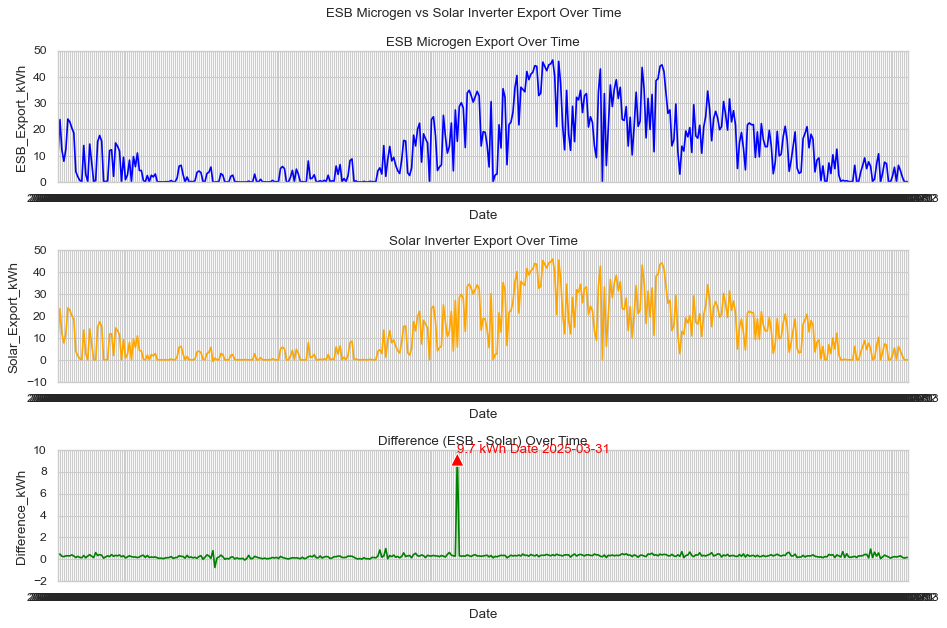

In [36]:
# Now plot each over time 
fig,ax = plt.subplots(3,1,figsize=(12,8))
fig.suptitle('ESB Microgen vs Solar Inverter Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='ESB_Export_kWh', ax=ax[0], color='blue')
ax[0].set_title('ESB Microgen Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Solar_Export_kWh', ax=ax[1], color='orange')
ax[1].set_title('Solar Inverter Export Over Time')
# calculate difference column
df_daily_esb_solar_merged['Difference_kWh'] = df_daily_esb_solar_merged['ESB_Export_kWh'] - df_daily_esb_solar_merged['Solar_Export_kWh']
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Difference_kWh', ax=ax[2], color='green')
ax[2].set_title('Difference (ESB - Solar) Over Time')
# annote arrow pointing  a point where difference is more than 5 kWh
for i, row in df_daily_esb_solar_merged.iterrows():
    if abs(row['Difference_kWh']) > 5:
        ax[2].annotate(f"{row['Difference_kWh']:.1f} kWh Date {row['Date']}", (row['Date'], row['Difference_kWh']),color='red',arrowprops=dict(facecolor='red', shrink=0.05))
plt.tight_layout()

__Reload data from exclude outliers__

In [37]:
# export from the tables to a data frame for reporting , ploting and analysis
df_daily_esb_solar_merged = pd.read_sql_query("""SELECT esb.Date,
                                                    esb.[Export Volume (kWh)] AS ESB_Export_kWh, 
                                                    solar.[Exported(kWh)] AS Solar_Export_kWh,
                                                    esb.[Export Volume (kWh)] - solar.[Exported(kWh)] AS Difference_kWh,
                                                    (esb.[Export Volume (kWh)] + solar.[Exported(kWh)])/2 AS Mean_kWh
                                             FROM daily_esb_microgen_data AS esb 
                                             INNER JOIN weekly_solar_data AS solar 
                                          ON esb.Date = solar.Date
                                              WHERE Difference_kWh < 5 AND Difference_kWh > -5
                                          """, con)
print("Daily ESB Microgen vs Solar DataFrame shape:", df_daily_esb_solar_merged.shape)
print("DataFrame info:")
print(df_daily_esb_solar_merged.info())

Daily ESB Microgen vs Solar DataFrame shape: (428, 5)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              428 non-null    object 
 1   ESB_Export_kWh    428 non-null    float64
 2   Solar_Export_kWh  428 non-null    float64
 3   Difference_kWh    428 non-null    float64
 4   Mean_kWh          428 non-null    float64
dtypes: float64(4), object(1)
memory usage: 16.8+ KB
None


__Plot Difference between ESB and Solar__

The outlier has been removed , and now the difference shows the bias. 


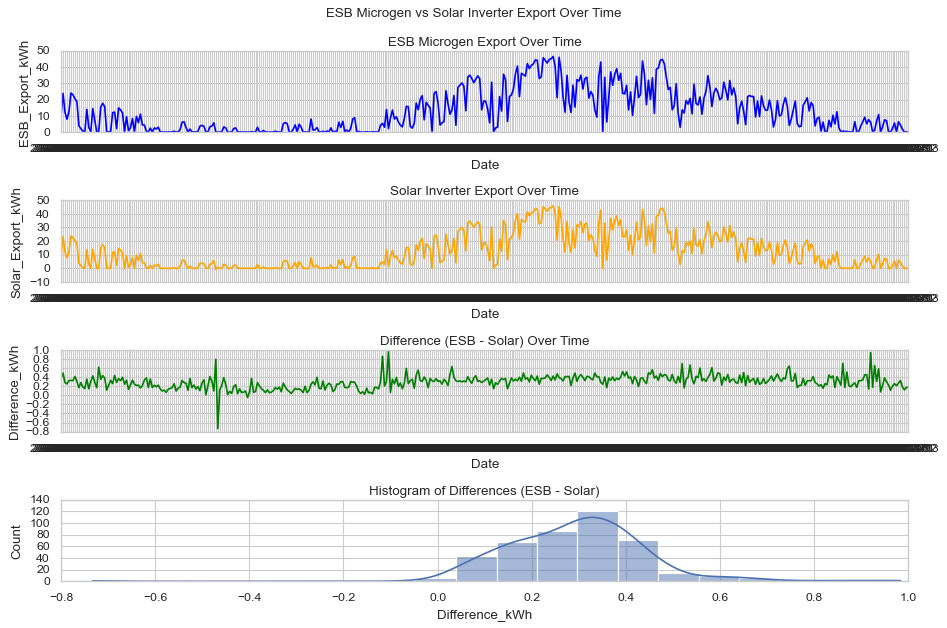

In [38]:
# Now plot each over time 
fig,ax = plt.subplots(4,1,figsize=(12,8))
fig.suptitle('ESB Microgen vs Solar Inverter Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='ESB_Export_kWh', ax=ax[0], color='blue')
ax[0].set_title('ESB Microgen Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Solar_Export_kWh', ax=ax[1], color='orange')
ax[1].set_title('Solar Inverter Export Over Time')
# calculate difference column
df_daily_esb_solar_merged['Difference_kWh'] = df_daily_esb_solar_merged['ESB_Export_kWh'] - df_daily_esb_solar_merged['Solar_Export_kWh']
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Difference_kWh', ax=ax[2], color='green')
ax[2].set_title('Difference (ESB - Solar) Over Time')
# annote arrow pointing  a point where difference is more than 5 kWh
for i, row in df_daily_esb_solar_merged.iterrows():
    if abs(row['Difference_kWh']) > 5:
        ax[2].annotate(f"{row['Difference_kWh']:.1f} kWh Date {row['Date']}", (row['Date'], row['Difference_kWh']),color='red',arrowprops=dict(facecolor='red', shrink=0.05))
plt.tight_layout()
# plot histogram of difference
sns.histplot(data=df_daily_esb_solar_merged, x='Difference_kWh', bins=20, kde=True)
plt.title('Histogram of Differences (ESB - Solar)')
plt.tight_layout()

##### Mean Bias Error

Mean Bias Error is the sume of the differences divided by the number of records

__Mean Bias Error__

$$MBE = \frac{1}{n} \sum_{i=1}^{n} (I_i - M_i)$$

$$MBE = \frac{\sum (Inverter_{kWh} - Meter_{kWh})}{TotalDays}$$

__Normalized Mean Bias Error__

$$NMBE (\%) = \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)}{(n \times \bar{y})} \times 100$$

$$NMBE (\%) = \frac{MBE}{\bar{y}_{ref}} \times 100$$


__Root mean square Error__

$$NMBE (\%) = \frac{MBE}{\bar{y}_{ref}} \times 100$$

$$RMSE = \sqrt{\frac{\sum (Inverter_{kWh} - Meter_{kWh})^2}{TotalDays}}$$


__Analysis__

Gemini Guidance

High MBE, Low RMSE: Your inverter is precise but consistently wrong (e.g., always reads +5%). This is easy to fix with a simple multiplication factor.   

Low MBE, High RMSE: Your inverter is accurate on average, but individual days fluctuate wildly (e.g., +10% one day, -10% the next). This is harder to fix and suggests synchronization issues or fluctuating efficiency.



In [39]:
markdown_lines = ["### Bias Summary Report", ""]

# calculate 
sum_of_differences = df_daily_esb_solar_merged['Difference_kWh'].sum()/df_daily_esb_solar_merged.shape[0]
# Also work out the average daily generation from solar inverter
average_solar_generation = df_daily_esb_solar_merged['Solar_Export_kWh'].sum()/df_daily_esb_solar_merged.shape[0]
markdown_lines.append(f"__Average Daily Solar Generation:__ {average_solar_generation:.4f} kWh")
markdown_lines.append(f"__Average Difference (ESB - Solar):__ {sum_of_differences:.4f} kWh")
# Now work otut the NMBE Percentage ( Normalized Mean Bias Error)
nmbe_percentage = (sum_of_differences / average_solar_generation) * 100
markdown_lines.append(f"__NMBE Percentage:__ {nmbe_percentage:.4f} %")

# now calculate the RMSE
df_daily_esb_solar_merged['Squared_Diff'] = df_daily_esb_solar_merged['Difference_kWh'] ** 2
rmse = np.sqrt(df_daily_esb_solar_merged['Squared_Diff'].mean())
markdown_lines.append(f"__RMSE (Root Mean Square Error):__ {rmse:.4f} kWh")
markdown_lines.append(f"__RMSE Percentage of Average Solar Generation:__ {(rmse / average_solar_generation) * 100:.4f} %")
markdown_lines.append(f"__Total Days Analyzed:__ {df_daily_esb_solar_merged.shape[0]} days")
markdown_lines.append(f"__Date Range Analyzed:__ {df_daily_esb_solar_merged['Date'].min()} to {df_daily_esb_solar_merged['Date'].max()}")
## Summary section
markdown_lines.append("\n---\n")
markdown_lines.append("**Summary**")
markdown_lines.append(" This is a High Precision , Low Accuracy System Comparison between the Solar Inverter and the ESB Utility Meter. ")
markdown_lines.append("The two devices differ by a consistent bias as indicated by the NMBE percentage. ")
markdown_lines.append("\n---\n")
display(Markdown('    \n'.join(markdown_lines)))

### Bias Summary Report    
    
__Average Daily Solar Generation:__ 12.4579 kWh    
__Average Difference (ESB - Solar):__ 0.2944 kWh    
__NMBE Percentage:__ 2.3634 %    
__RMSE (Root Mean Square Error):__ 0.3308 kWh    
__RMSE Percentage of Average Solar Generation:__ 2.6555 %    
__Total Days Analyzed:__ 428 days    
__Date Range Analyzed:__ 2024-09-11 to 2025-11-13    

---
    
**Summary**    
 This is a High Precision , Low Accuracy System Comparison between the Solar Inverter and the ESB Utility Meter.     
The two devices differ by a consistent bias as indicated by the NMBE percentage.     

---


#### Plot Difference distribution with BIAS



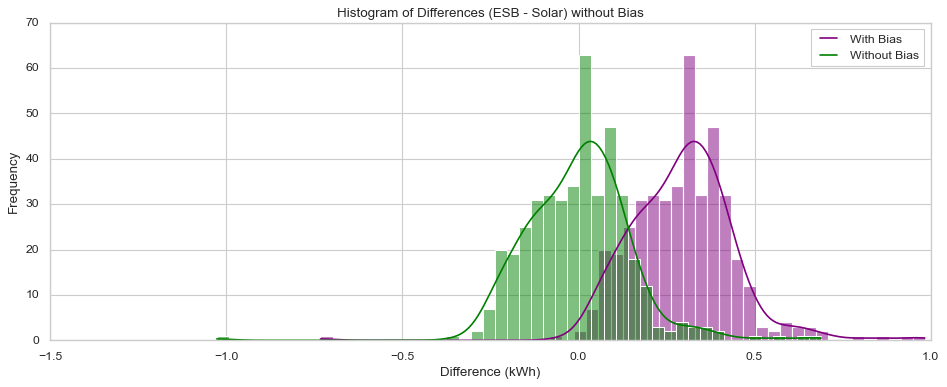

In [55]:
# Plot the histogram of differences , with and without bias on the same plot
fig ,ax = plt.subplots(1,1,figsize=(12,5))
# First plot histogram of differences with bias
sns.histplot(data=df_daily_esb_solar_merged, x='Difference_kWh', bins=50, kde=True, color='purple', ax=ax)
ax.set_title('Histogram of Differences (ESB - Solar) with Bias')
ax.set_xlabel('Difference (kWh)')
ax.set_ylabel('Frequency')
# Now plot histogram of differences after removing bias
df_daily_esb_solar_merged['Difference_kWh_No_Bias'] = df_daily_esb_solar_merged['Difference_kWh'] - sum_of_differences
sns.histplot(data=df_daily_esb_solar_merged, x='Difference_kWh_No_Bias', bins=50, kde=True, color='green', ax=ax)
ax.set_title('Histogram of Differences (ESB - Solar) without Bias')
ax.set_xlabel('Difference (kWh)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.legend(labels=['With Bias','Without Bias'])
plt.show()

### Bland-Altman Plot


The Bland-Altman plot is used to visually identify if there are any issues between the two sensors. The difference is plotted again the mean of the two measures. It is used to identify the bias , and visually compare the error.  The bias can either be a proportional bias or a systemic bias.  
This bias looks like a function of both , proportional bias because the trend line is increasing , and systemic bias because the line is offset..



[Wiki Band Altman Plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot)
[Seaborn Regression Plot](https://seaborn.pydata.org/generated/seaborn.regplot.html)

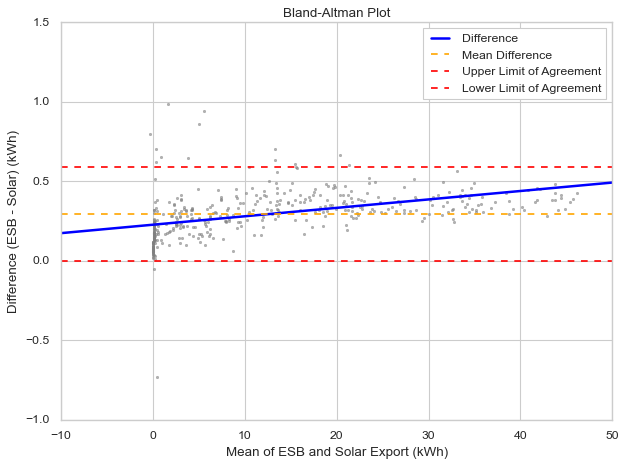

In [41]:
# Bland altman plot
fig , ax = plt.subplots(1,1,figsize=(8,6))
# use a regression plot with scatter points and a line for mean and limits of agreement

#sns.scatterplot(data=df_daily_esb_solar_merged, x='Mean_kWh', y='Difference_kWh', ax=ax)
sns.regplot(data=df_daily_esb_solar_merged, x='Mean_kWh', y='Difference_kWh', ax=ax, 
            scatter=True, ci=None,truncate=False,
             line_kws={'color':'blue','label':'Difference'},
             scatter_kws={'color':'gray','s':5,'alpha':0.6} )
mean_diff = df_daily_esb_solar_merged['Difference_kWh'].mean()
std_diff = df_daily_esb_solar_merged['Difference_kWh'].std()
ax.axhline(mean_diff, color='orange', linestyle='--', label='Mean Difference')
ax.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', label='Upper Limit of Agreement')
ax.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', label='Lower Limit of Agreement')
ax.set_title('Bland-Altman Plot')
ax.set_xlabel('Mean of ESB and Solar Export (kWh)')
ax.set_ylabel('Difference (ESB - Solar) (kWh)')
ax.legend()
plt.tight_layout()
plt.show()

#### Other plots

Look into wilcox

https://seaborn.pydata.org/generated/seaborn.histplot.html
https://seaborn.pydata.org/generated/seaborn.boxplot.html
https://seaborn.pydata.org/generated/seaborn.violinplot.html


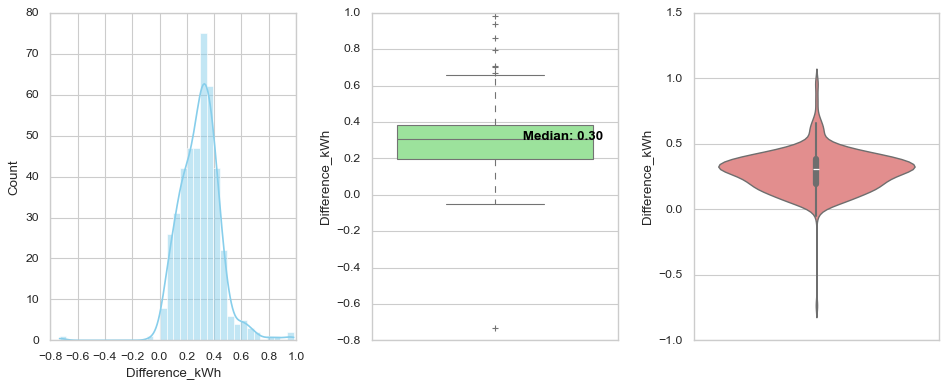

In [42]:
# 2. Create the Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
# Plot zero difference historgram
sns.histplot(df_daily_esb_solar_merged['Difference_kWh'], kde=True, ax=axes[0], color='skyblue' )
sns.boxplot(y=df_daily_esb_solar_merged['Difference_kWh'], ax=axes[1], color='lightgreen')
sns.violinplot(y=df_daily_esb_solar_merged['Difference_kWh'], ax=axes[2], color='lightcoral')
# add note of median
median_val = df_daily_esb_solar_merged['Difference_kWh'].median()
axes[1].text(0.1, median_val, f' Median: {median_val:.2f}', 
             color='black', weight='bold', ha='left')
plt.tight_layout()
plt.show()

## Predicting Solar Output from Weather

The object of this part of the project is to use numerical methods to predict the solar panel output based on weather data.

There are two sources of data , the solar system power generation rate , and the weather data which includes solar radiation , temperature and humidity. 

Various methods will be tried to compare there accuracy.

### Data Preperation

Both sources of data have already been loaded into data frames. 

__Solar Data : df_raw_daily_solar__

This has a grain of 5 minute intervals with measure for PV(W) - Solar Power

__ Weather : df_weather__

This has a grain of 10 minute intervals with measures for Temperature , Humidity and Solar Radiance.

The following will be done

1. Both data sets will be converted to the same grain ( 10 minute intervals) . 
2. The data sets will be merged into 1 data set
3. The data set will be normalized using the min max approach
4. The date time will be normalized using a data cyclic approach ( sine ) with the centre on the summer soltice

[Pandas : Resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

__Solar__

In [43]:
# Get the columns DateTime, PV(W) and only get times every 10 minutes
df_solar_10min = df_raw_daily_solar[['DateTime', 'PV(W)']].copy()
# filter to only keep rows where minute is multiple of 10 - because it is at 5 minute intervals
df_solar_10min = df_solar_10min[df_solar_10min['DateTime'].dt.minute % 10 == 0]
df_solar_10min.set_index('DateTime', inplace=True)
df_solar_10min.sort_index(inplace=True)

__Weather__

In [44]:
# Weather data also at 10 minute intervals so set index to DateTime
df_weather_10min = weather_df.copy()
# sort index
df_weather_10min.sort_index(inplace=True)
print("df_wather_10min shape:", df_weather_10min.shape)
print("df_solar_10min info:")
df_solar_10min.info()
print("df_weather_10min info:")
df_solar_10min.info()
# set index to DateTime
df_weather_10min.set_index('DateTime', inplace=True)
# Sort index
df_weather_10min.sort_index(inplace=True)


df_wather_10min shape: (100885, 5)
df_solar_10min info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58846 entries, 2024-09-12 00:00:00 to 2025-10-31 23:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PV(W)   58846 non-null  float64
dtypes: float64(1)
memory usage: 919.5 KB
df_weather_10min info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58846 entries, 2024-09-12 00:00:00 to 2025-10-31 23:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PV(W)   58846 non-null  float64
dtypes: float64(1)
memory usage: 919.5 KB


__Merge__

[merge_asof](https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html)

In [45]:
# Merge asof to get nearest time match
df_merged_10min = pd.merge_asof(left = df_solar_10min,
                                right = df_weather_10min, left_index=True, right_index=True, direction='nearest')
print("Merged 10-minute DataFrame shape:", df_merged_10min.shape)
# Now merge with copernicus solar data at 10 minute intervals
df_copernicus_10min = df_copernicus_solar[['DateTime','GHI']].copy()
df_copernicus_10min.set_index('DateTime', inplace=True)
df_copernicus_10min.sort_index(inplace=True)
df_merged_10min = pd.merge_asof(left = df_merged_10min,
                                right = df_copernicus_10min, left_index=True, right_index=True, direction='nearest')
print("Final Merged 10-minute DataFrame shape:", df_merged_10min.shape)
# Now add datetime derived columns for analysis
# All centered around summer soltstice June 21 and noon , normalized between 0 and 1 using sin function
# Month of year, day of year, hour of day
df_merged_10min['Month_Sin'] = np.sin(2 * np.pi * (df_merged_10min.index.month - 1) / 12)
df_merged_10min['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merged_10min.index.dayofyear - 1) / 365)
df_merged_10min['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merged_10min.index.hour) / 24)
print("Final Merged DataFrame shape:", df_merged_10min.shape)
df_merged_10min.reset_index(inplace=True)
print("DataFrame info:")
df_merged_10min.info()
print("Columns:", df_merged_10min.columns.tolist())

Merged 10-minute DataFrame shape: (58846, 5)
Final Merged 10-minute DataFrame shape: (58846, 6)
Final Merged DataFrame shape: (58846, 9)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58846 entries, 0 to 58845
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                58846 non-null  datetime64[ns]
 1   PV(W)                   58846 non-null  float64       
 2   Temperature(C)          58846 non-null  Float64       
 3   Humidity(%)             58846 non-null  Float64       
 4   Solar Radiation(W/m^2)  58846 non-null  Float64       
 5   Condition Code          58846 non-null  Float64       
 6   GHI                     58846 non-null  float64       
 7   Month_Sin               58846 non-null  float64       
 8   DayOfYear_Sin           58846 non-null  float64       
 9   HourOfDay_Sin           58846 non-null  float64       
dtypes: Float64(4)

__Histograms of each of the measures__

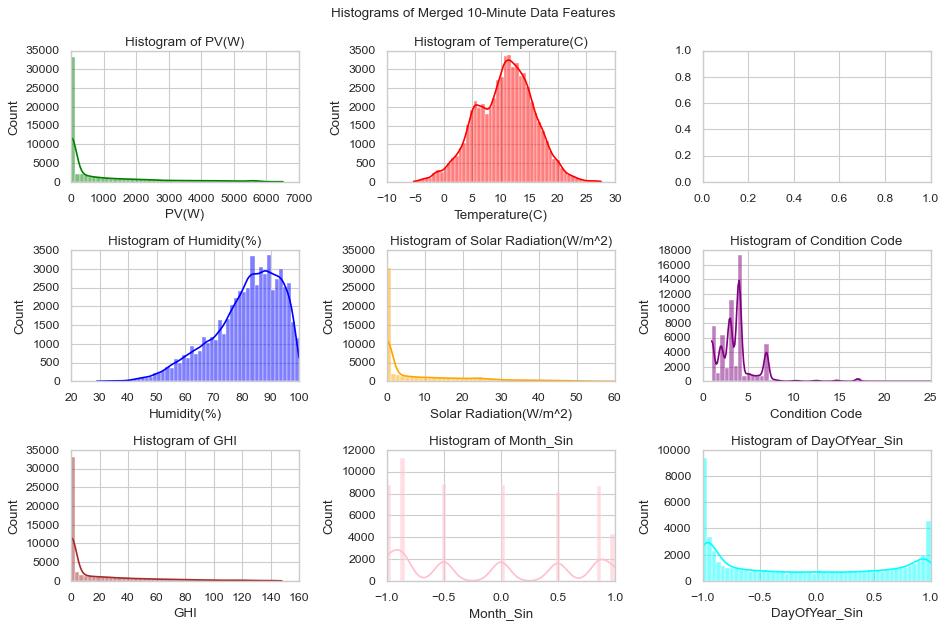

In [46]:
# histogram of of all the measures/features
fig, ax = plt.subplots(3,3, figsize=(12,8))
fig.suptitle('Histograms of Merged 10-Minute Data Features')
sns.histplot(data=df_merged_10min, x='PV(W)', bins=50, kde=True, ax=ax[0,0], color='green')
ax[0,0].set_title('Histogram of PV(W)')
sns.histplot(data=df_merged_10min, x='Temperature(C)', bins=50, kde=True, ax=ax[0,1], color='red')
ax[0,1].set_title('Histogram of Temperature(C)')
sns.histplot(data=df_merged_10min, x='Humidity(%)', bins=50, kde=True, ax=ax[1,0], color='blue')
ax[1,0].set_title('Histogram of Humidity(%)')
sns.histplot(data=df_merged_10min, x='Solar Radiation(W/m^2)', bins=50, kde=True, ax=ax[1,1], color='orange')
ax[1,1].set_title('Histogram of Solar Radiation(W/m^2)')
sns.histplot(data=df_merged_10min, x='Condition Code', bins=50, kde=True, ax=ax[1,2], color='purple')
ax[1,2].set_title('Histogram of Condition Code')
sns.histplot(data=df_merged_10min, x='GHI', bins=50, kde=True, ax=ax[2,0], color='brown')
ax[2,0].set_title('Histogram of GHI')
sns.histplot(data=df_merged_10min, x='Month_Sin', bins=50, kde=True, ax=ax[2,1], color='pink')
ax[2,1].set_title('Histogram of Month_Sin')
sns.histplot(data=df_merged_10min, x='DayOfYear_Sin', bins=50, kde=True, ax=ax[2,2], color='cyan')
ax[2,2].set_title('Histogram of DayOfYear_Sin')
plt.tight_layout()
plt.show()

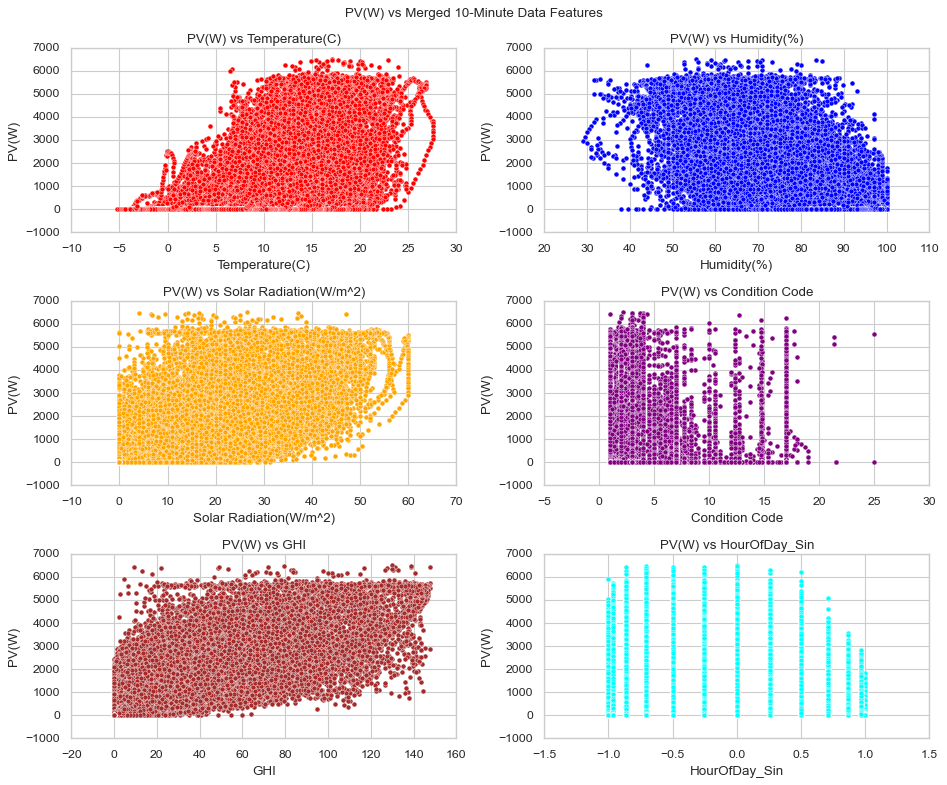

In [47]:
# Do a pairplot to see relationships between features
#sns.pairplot(df_merged_10min[['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)','Condition Code']])
#plt.suptitle('Pairplot of Merged 10-Minute Data Features', y=1.02)
#plt.show()
# Plot the target variable PV(W) against each feature
fig, ax = plt.subplots(3,2, figsize=(12,10))
fig.suptitle('PV(W) vs Merged 10-Minute Data Features')
sns.scatterplot(data=df_merged_10min, x='Temperature(C)', y='PV(W)', ax=ax[0,0], color='red')
ax[0,0].set_title('PV(W) vs Temperature(C)')
sns.scatterplot(data=df_merged_10min, x='Humidity(%)', y='PV(W)', ax=ax[0,1], color='blue')
ax[0,1].set_title('PV(W) vs Humidity(%)')           
sns.scatterplot(data=df_merged_10min, x='Solar Radiation(W/m^2)', y='PV(W)', ax=ax[1,0], color='orange')
ax[1,0].set_title('PV(W) vs Solar Radiation(W/m^2)')           
sns.scatterplot(data=df_merged_10min, x='Condition Code', y='PV(W)', ax=ax[1,1], color='purple')
ax[1,1].set_title('PV(W) vs Condition Code')           
sns.scatterplot(data=df_merged_10min, x='GHI', y='PV(W)', ax=ax[2,0], color='brown')
ax[2,0].set_title('PV(W) vs GHI')           
sns.scatterplot(data=df_merged_10min, x='HourOfDay_Sin', y='PV(W)', ax=ax[2,1], color='cyan')
ax[2,1].set_title('PV(W) vs HourOfDay_Sin')           
plt.tight_layout()
plt.show()

_Normalization_

The Min Max Scaler is used from scipy. This will convert each of the features or measures to a value between 0 -  1. This helps in traing. If the data is not scaled then there is a risk that one measure will override the others because of it's large relative magitude.

(MinMaxScaler)[https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html] 





In [48]:
# Normalize the data using Min-Max scaling
# check if scikit-learn is installed , only needed in Jupyter notebooks
#!pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_merged_10min_normalized = scaler.fit_transform(df_merged_10min[['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin','GHI']])
df_merged_10min_normalized = pd.DataFrame(df_merged_10min_normalized, columns=['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin','GHI'])
print("Normalized 10-minute DataFrame shape:", df_merged_10min_normalized.shape)
print("DataFrame info:")
df_merged_10min_normalized.info()
print("Columns:", df_merged_10min_normalized.columns.tolist())



Normalized 10-minute DataFrame shape: (58846, 9)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58846 entries, 0 to 58845
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PV(W)                   58846 non-null  float64
 1   Temperature(C)          58846 non-null  float64
 2   Humidity(%)             58846 non-null  float64
 3   Solar Radiation(W/m^2)  58846 non-null  float64
 4   Condition Code          58846 non-null  float64
 5   Month_Sin               58846 non-null  float64
 6   DayOfYear_Sin           58846 non-null  float64
 7   HourOfDay_Sin           58846 non-null  float64
 8   GHI                     58846 non-null  float64
dtypes: float64(9)
memory usage: 4.0 MB
Columns: ['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'GHI']


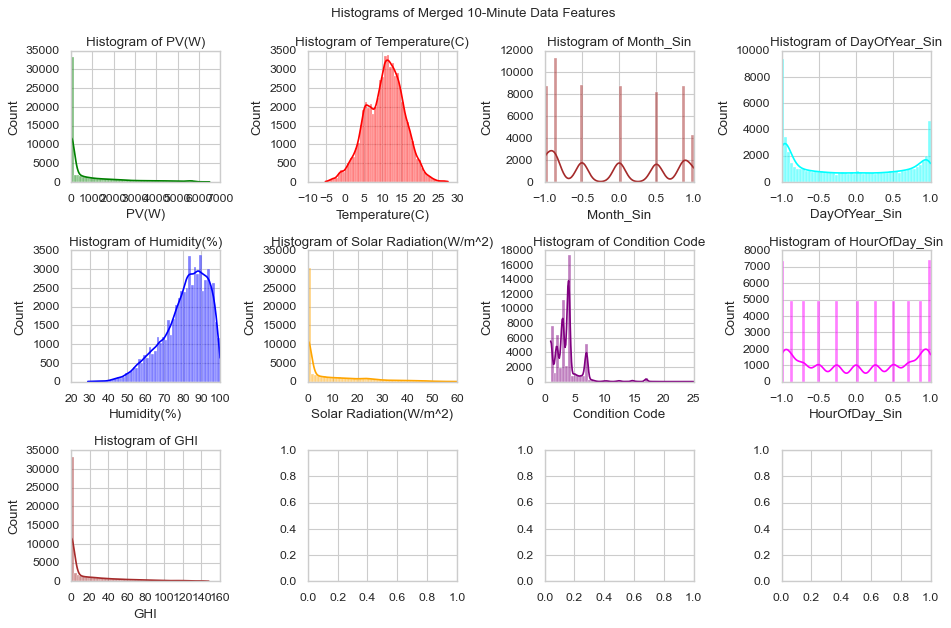

In [49]:
# histogram of of all the measures/features
fig, ax = plt.subplots(3,4, figsize=(12,8))
fig.suptitle('Histograms of Merged 10-Minute Data Features')
sns.histplot(data=df_merged_10min, x='PV(W)', bins=50, kde=True, ax=ax[0,0], color='green')
ax[0,0].set_title('Histogram of PV(W)')
sns.histplot(data=df_merged_10min, x='Temperature(C)', bins=50, kde=True, ax=ax[0,1], color='red')
ax[0,1].set_title('Histogram of Temperature(C)')
sns.histplot(data=df_merged_10min, x='Humidity(%)', bins=50, kde=True, ax=ax[1,0], color='blue')
ax[1,0].set_title('Histogram of Humidity(%)')
sns.histplot(data=df_merged_10min, x='Solar Radiation(W/m^2)', bins=50, kde=True, ax=ax[1,1], color='orange')
ax[1,1].set_title('Histogram of Solar Radiation(W/m^2)')
sns.histplot(data=df_merged_10min, x='Condition Code', bins=50, kde=True, ax=ax[1,2], color='purple')
ax[1,2].set_title('Histogram of Condition Code')
sns.histplot(data=df_merged_10min, x='Month_Sin', bins=50, kde=True, ax=ax[0,2], color='brown')
ax[0,2].set_title('Histogram of Month_Sin')
sns.histplot(data=df_merged_10min, x='DayOfYear_Sin', bins=50, kde=True, ax=ax[0,3], color='cyan')
ax[0,3].set_title('Histogram of DayOfYear_Sin')
sns.histplot(data=df_merged_10min, x='HourOfDay_Sin', bins=50, kde=True, ax=ax[1,3], color='magenta')
ax[1,3].set_title('Histogram of HourOfDay_Sin')
sns.histplot(data=df_merged_10min, x='GHI', bins=50, kde=True, ax=ax[2,0], color='brown')
ax[2,0].set_title('Histogram of GHI')

plt.tight_layout()
plt.show()

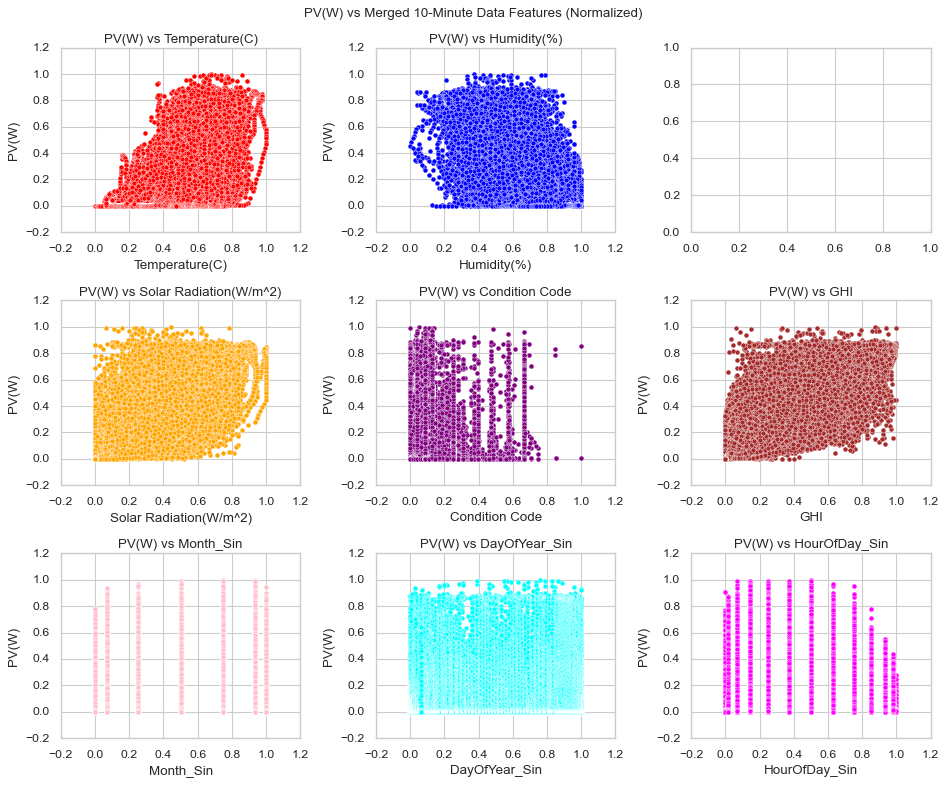

In [50]:
# Do a pairplot to see relationships between features
# Plot the target variable PV(W) against each feature
fig, ax = plt.subplots(3,3, figsize=(12,10))
fig.suptitle('PV(W) vs Merged 10-Minute Data Features (Normalized)')
sns.scatterplot(data=df_merged_10min_normalized, x='Temperature(C)', y='PV(W)', ax=ax[0,0], color='red')
ax[0,0].set_title('PV(W) vs Temperature(C)')
sns.scatterplot(data=df_merged_10min_normalized, x='Humidity(%)', y='PV(W)', ax=ax[0,1], color='blue')
ax[0,1].set_title('PV(W) vs Humidity(%)')           
sns.scatterplot(data=df_merged_10min_normalized, x='Solar Radiation(W/m^2)', y='PV(W)', ax=ax[1,0], color='orange')
ax[1,0].set_title('PV(W) vs Solar Radiation(W/m^2)')           
sns.scatterplot(data=df_merged_10min_normalized, x='Condition Code', y='PV(W)', ax=ax[1,1], color='purple')     
ax[1,1].set_title('PV(W) vs Condition Code')      
sns.scatterplot(data=df_merged_10min_normalized, x='GHI', y='PV(W)', ax=ax[1,2], color='brown')
ax[1,2].set_title('PV(W) vs GHI')           
sns.scatterplot(data=df_merged_10min_normalized, x='Month_Sin', y='PV(W)', ax=ax[2,0], color='pink')
ax[2,0].set_title('PV(W) vs Month_Sin')           
sns.scatterplot(data=df_merged_10min_normalized, x='DayOfYear_Sin', y='PV(W)', ax=ax[2,1], color='cyan')
ax[2,1].set_title('PV(W) vs DayOfYear_Sin')           
sns.scatterplot(data=df_merged_10min_normalized, x='HourOfDay_Sin', y='PV(W)', ax=ax[2,2], color='magenta')
ax[2,2].set_title('PV(W) vs HourOfDay_Sin')           
plt.tight_layout()
plt.show()

### Apply random forrest

[SCIKIT Learn - Random Forrest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

[Shelf learning - Random Forrect](https://shelf.io/blog/random-forests-in-machine-learning/)   

[Google - Random Forrest](https://developers.google.com/machine-learning/decision-forests/random-forests)

[SCIKIT Learn - train_test_Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [51]:
feature_cols = ['Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'GHI']
target_col = 'PV(W)'

In [52]:

# Define features and target variable
# exclude PV(W) which is close to zero most of the time
threshold = 0.001
mask = df_merged_10min_normalized['PV(W)'] > threshold
X = df_merged_10min_normalized.loc[mask, feature_cols]
y = df_merged_10min_normalized.loc[mask, target_col]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=16,min_samples_split=5,min_samples_leaf=2)
# Train the model
rf_model.fit(X_train, y_train)
# Make predictions
y_pred = rf_model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Calculate MAPE , ignore division by zero warnings
import numpy as np  
# Exclude values below a threshold (e.g., 0.01)
threshold = 0.01
mask = np.abs(y_test) > threshold
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]
print(f"Number of samples used for MAPE calculation: {len(y_test_filtered)}")
print(f"Total samples in y_test: {len(y_test)}")
mape = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100
print(f"MAPE (threshold={threshold}): {mape:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")
# ...existing code...
# Feature importance
importances = rf_model.feature_importances_
feature_names = X.columns
for feature, importance in zip(feature_names, importances):
    print(f"Feature: {feature}, Importance: {importance}")  
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest Regressor')
# plot the test zeros vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual PV(W) (Normalized)')
plt.ylabel('Predicted PV(W) (Normalized)')
plt.title('Actual vs Predicted PV(W)')
# plot a diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
# plot standard deviation lines diagonally
std_dev = np.std(y_test - y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test) + std_dev, max(y_test) + std_dev], color='orange', 
         linestyle='--', label='+1 Std Dev')
plt.plot([min(y_test), max(y_test)], [min(y_test) - std_dev, max(y_test) - std_dev], color='orange', 
         linestyle='--', label='-1 Std Dev')
# plot a line for the test threshold horizontal
plt.axvline(x=threshold, color='green', linestyle='--', label='Threshold Line')
plt.legend()
# Plot error distribution
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=50, kde=True)
# add columns for mean and std dev lines
mean_error = np.mean(errors)
std_error = np.std(errors)
plt.axvline(mean_error, color='red', linestyle='--', label='Mean Error')
plt.axvline(mean_error + std_error, color='orange', linestyle='--', label='+1 Std Dev')
plt.axvline(mean_error - std_error, color='orange', linestyle='--', label='-1 Std Dev')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()
# how good is the prediction

NameError: name 'train_test_split' is not defined

Now convert back to real values

In [ ]:
# convert the normalized predictions back to original scale
y_test_original = y_test * (df_merged_10min['PV(W)'].max() - df_merged_10min['PV(W)'].min()) + df_merged_10min['PV(W)'].min()
y_pred_original = y_pred * (df_merged_10min['PV(W)'].max() - df_merged_10min['PV(W)'].min()) + df_merged_10min['PV(W)'].min()
# calculate MAPE on original scale
threshold_original = 0.01 * (df_merged_10min['PV(W)'].max() - df_merged_10min['PV(W)'].min()) + df_merged_10min['PV(W)'].min()
mask_original = np.abs(y_test_original) > threshold_original
y_test_original_filtered = y_test_original[mask_original]
y_pred_original_filtered = y_pred_original[mask_original]
mape_original = np.mean(np.abs((y_test_original_filtered - y_pred_original_filtered) / y_test_original_filtered)) * 100

print(f"MAPE on original scale (threshold={threshold_original}): {mape_original:.2f}%")
# scatter plot of actual vs predicted on original scale
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.xlabel('Actual PV(W) (Original Scale)')
plt.ylabel('Predicted PV(W) (Original Scale)')
plt.title('Actual vs Predicted PV(W) on Original Scale')
# plot a diagonal line
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
# Plot error distribution on original scale
errors_original = y_test_original - y_pred_original
plt.figure(figsize=(8, 6))
sns.histplot(errors_original, bins=50, kde=True)
# plot histogram of errors
plt.xlabel('Prediction Error (Original Scale)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors on Original Scale')
plt.grid(True)
plt.tight_layout()
plt.legend()
# plot error distribution as a wisker plot on original scale
plt.figure(figsize=(8, 3))
sns.boxplot(x=errors_original)
plt.xlabel('Prediction Error (Original Scale)')
plt.title('Boxplot of Prediction Errors on Original Scale')
plt.grid(True)
plt.tight_layout()
plt.show()

### Now try xboost

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Define Features (X) and Target (y)
# Dropping 'DateTime' as XGBoost needs numerical inputs, and 'PV(W)' because it's the target
features = ['Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 
            'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'GHI']
target = 'PV(W)'

X = df_merged_10min[features]
y = df_merged_10min[target]

# 2. Split into Train and Test sets (80% Train, 20% Test)
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

In [ ]:
# 3. Initialize XGBoost Regressor
# n_estimators: Number of boosting rounds (trees)
# learning_rate: Step size shrinkage used to prevent overfitting
# max_depth: Maximum depth of a tree
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                          n_estimators=100, 
                          learning_rate=0.1, 
                          max_depth=5, 
                          random_state=42)

# 4. Fit the model
print("Training XGBoost model...")
xg_reg.fit(X_train, y_train)
print("Training complete.")

In [ ]:
# 5. Make Predictions
y_pred = xg_reg.predict(X_test)

# 6. Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} W")
print(f"Mean Absolute Error (MAE): {mae:.2f} W")

# 7. Visualize Actual vs Predicted (First 100 test points for clarity)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 100 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

# 8. Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xg_reg, max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()

### Light Gradient Boosting

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Setup Data (Same as XGBoost)
# We use the same features and target
features = ['Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 
            'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
target = 'PV(W)'

X = df_merged_10min[features]
y = df_merged_10min[target]

# Split data (using the same seed '42' ensures we compare apples-to-apples with XGBoost)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize LightGBM Regressor
# n_estimators: Number of trees
# learning_rate: Speed of learning
# num_leaves: Main parameter to control complexity (LightGBM grows leaf-wise)
lgbm_reg = LGBMRegressor(n_estimators=100,
                         learning_rate=0.1,
                         num_leaves=31,  # Default is 31
                         random_state=42,
                         n_jobs=-1)      # Use all CPU cores

# 3. Fit the model
print("Training LightGBM model...")
lgbm_reg.fit(X_train, y_train)
print("Training complete.")

In [ ]:
# 4. Make Predictions
y_pred_lgbm = lgbm_reg.predict(X_test)

# 5. Calculate Errors
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print(f"LightGBM RMSE: {rmse_lgbm:.2f} W")
print(f"LightGBM MAE: {mae_lgbm:.2f} W")

# 6. Compare Actual vs Predicted (First 100 samples)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual PV(W)', color='blue', alpha=0.6)
plt.plot(y_pred_lgbm[:100], label='LightGBM Prediction', color='green', linestyle='--', alpha=0.8)
plt.title('LightGBM: Actual vs Predicted Solar Output (First 100 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

# 7. Feature Importance
# LightGBM provides a convenient plot_importance function
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgbm_reg, max_num_features=10, importance_type='split')
plt.title('LightGBM Feature Importance')
plt.show()

## Cleanup

In [ ]:
# Close the database connection
#sys_cur.close()
#con.close()